<a href="https://colab.research.google.com/github/atlaie/Breathwork/blob/main/Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
from transformers import pipeline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import matplotlib as mpl
from nltk import sent_tokenize
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
sns.set_style('white')
plt.rcParams['font.size'] = 20
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

basedir = '/content/drive/MyDrive/Laptop_Info/BreathWork/'

Mounted at /content/drive


In [ ]:
doComputation = False
if doComputation:
    import nltk

    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')

    batch_size = 32 # Choose an appropriate batch size
    # These candidates labels come from https://www.pnas.org/doi/10.1073/pnas.1702247114
    candidate_labels = ['adoration', 'admiration', 'aesthetic experience','amusement', 'anger', 'anxiety', 'awe', 'awkwardness', 'boredom', 'calmness', 'confusion',
                        'craving', 'disgust', 'empathy', 'entrancement', 'excitement', 'fear', 'horror', 'interest', 'joy', 'nostalgia', 'pain', 'relief',
                        'romance', 'sadness', 'satisfaction', 'sexual desire', 'surprise']

    # We read all of our reports.
    files = glob.glob('/content/drive/MyDrive/Laptop_Info/BreathWork/EnglishTranscripts/*English.txt', recursive=True)

    # Initializing where the emotion probabilities will be stored.
    scores = []

    # In order to assign a probability to each of the candidate labels, we will deploy a pretrained LLM.
    # Particularly, making use of HugginFace's pipeline, without training (zero-shot classification), we
    # can directly make use of Meta's BART (https://arxiv.org/abs/1910.13461), trained on the
    # MultiNLI (MNLI) dataset (https://huggingface.co/datasets/multi_nli).

    classifier = pipeline("zero-shot-classification", model="sileod/deberta-v3-base-tasksource-nli", device = 0, multi_label = True)

    # Initializing where the emotion probabilities will be stored.
    scores = []

    # Loop over participants.
    for jj, text in enumerate(files):
      with open(text, "r") as fic:
          content = fic.read().replace('\n', ' ').replace('...', '... ')

      sentences = sent_tokenize(content)
      scores2 = np.zeros((len(sentences), len(candidate_labels)))

      for ii in range(0, len(sentences), batch_size):
          batch_sentences = sentences[ii:ii + batch_size]
          claf = classifier(batch_sentences, candidate_labels)
          for j, label in enumerate(candidate_labels):
              scores2[ii:ii + batch_size, j] = [x['scores'][x['labels'].index(label)] for x in claf]

      scores.append(scores2)
      print(f"{jj+1} is done")
    np.savez('/content/drive/MyDrive/Laptop_Info/BreathWork/Scores_MultiLabel_PerParticipant_English_12102023.npz', *scores)

In [ ]:
import glob
import pandas as pd
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
files = glob.glob('/content/drive/MyDrive/Laptop_Info/BreathWork/EnglishTranscripts/*English.txt', recursive=True)

tokenized_sentences = []

for file_path in files:
    with open(file_path, "r") as file:
        content = file.read().replace('\n', ' ').replace('...', '... ')
        sentences = sent_tokenize(content)
        tokenized_sentences.extend(sentences)

# Create a DataFrame with a single column containing all tokenized sentences
df = pd.DataFrame({'Tokenized Sentences': tokenized_sentences})


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


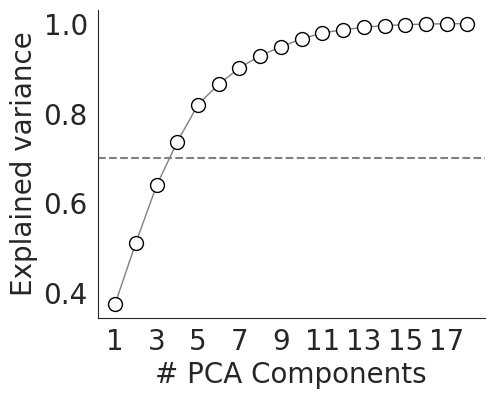

In [ ]:
#Plot PCA/variance ratio for the median of 18 people
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
scores = np.load('/content/drive/MyDrive/Laptop_Info/BreathWork/Scores_MultiLabel_PerParticipant_English_12102023.npz', allow_pickle = True)
candidate_labels = ['adoration', 'admiration', 'aesthetic experience','amusement', 'anger', 'anxiety', 'awe', 'awkwardness', 'boredom', 'calmness', 'confusion',
                    'craving', 'disgust', 'empathy', 'entrancement', 'excitement', 'fear', 'horror', 'interest', 'joy', 'nostalgia', 'pain', 'relief',
                    'romance', 'sadness', 'satisfaction', 'sexual desire', 'surprise']
candidate_labels2 = ['admiration', 'adoration', 'awe', 'aesthetic experience', 'entrancement', 'calmness', 'confusion', 'boredom', 'nostalgia',
                    'romance', 'sexual desire', 'craving', 'sadness', 'pain', 'anger', 'disgust', 'horror', 'fear', 'anxiety',
                    'awkwardness', 'amusement', 'relief', 'satisfaction', 'interest', 'surprise', 'excitement', 'joy', 'empathy']
newOrder = []
for ii, elem in enumerate(candidate_labels2):
    if elem != 'pain':
        newOrder.append([i for i, e in enumerate(candidate_labels) if e == elem][0])
    else:
        newOrder.append([i for i, e in enumerate(candidate_labels) if e == 'empathy'][0])

newOrder = np.array(newOrder)
labels = [' ' + label for label in candidate_labels2.copy()]
#Perform the PCA
np.set_printoptions(precision=2)

arr_fin = np.full((len(scores), len(labels)), np.nan)

for ii, key in enumerate(scores.keys()):

    arr_fin[ii, :] = np.nanmedian(scores[key][:,newOrder], axis = 0)

n=18
pca=PCA(n_components=n)
pca.fit(arr_fin)
var_pca=pca.explained_variance_ratio_   #gives the variace represented by each PCA component

fig, ax = plt.subplots(figsize = (5, 4))
plt.plot(np.arange(1,n+1),np.cumsum(var_pca),lw = 1, color = 'black', alpha = 0.5)
plt.plot(np.arange(1,n+1),np.cumsum(var_pca),marker='o',markersize=10, color = 'black', ls = '', mfc = 'white')
plt.xticks(np.arange(1,n+1)[::2])
plt.xlabel('# PCA Components')
plt.ylabel('Explained variance')
plt.axhline(0.7, ls = '--', color = 'gray')
plt.savefig(basedir+'VarianceExplained_PCAEmotions_19062024.svg', transparent = True)

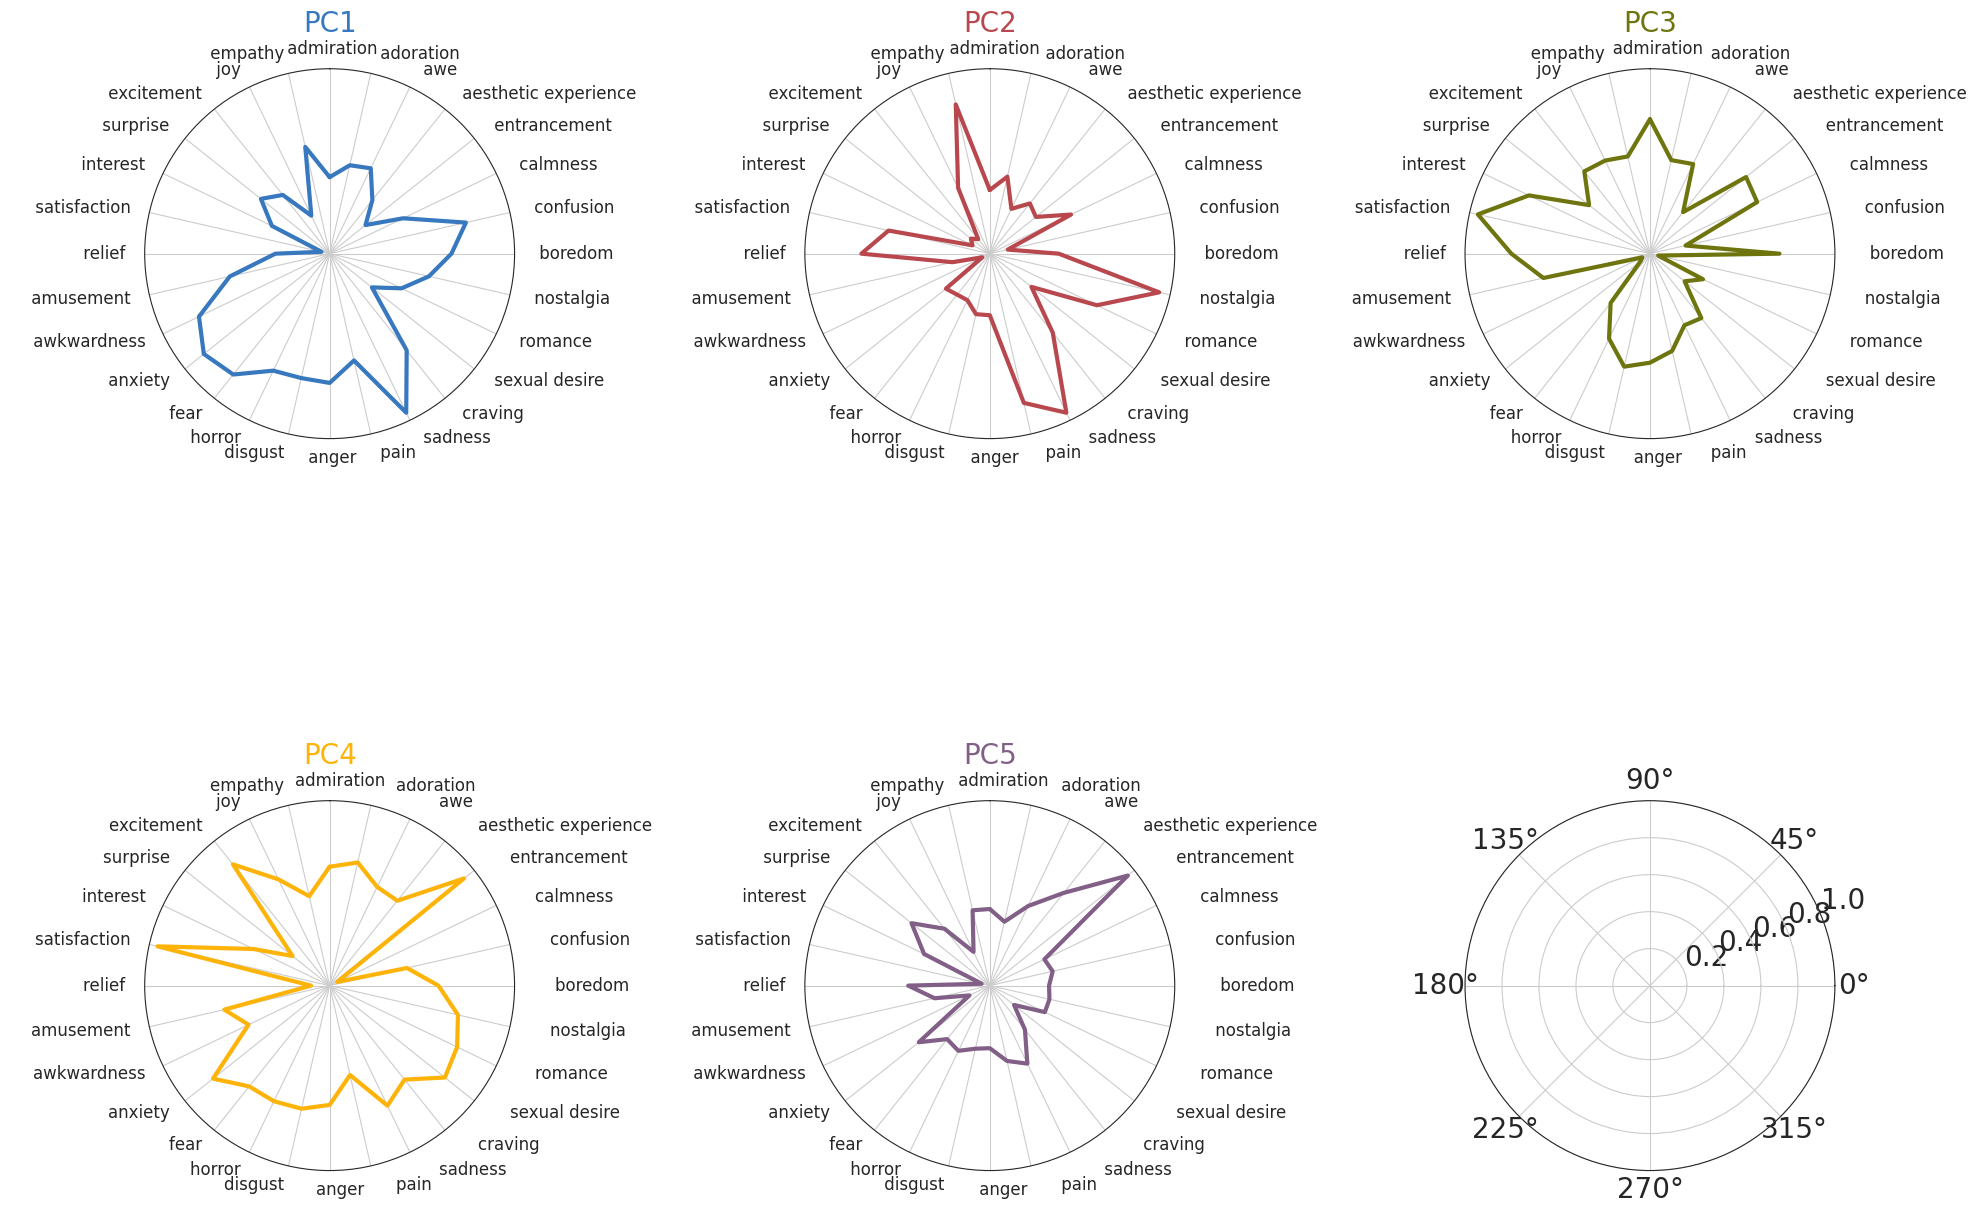

In [ ]:
import os
from natsort import natsorted
no_music = np.array(['ALEROMA', 'AURORA', 'DODO', 'FRESH', 'GIAC', 'LEONIE', 'LINUS', 'LUDO', 'MATT', 'MERIAM'])
file_path = natsorted(glob.glob('/content/drive/MyDrive/Laptop_Info/BreathWork/HR_Data/*.txt', recursive = True))

participants = np.array([os.path.splitext(os.path.basename(name))[0].replace(" DURING", "") for name in file_path])
music = participants[~np.in1d(participants, no_music)]
music_indices = np.where(~np.in1d(participants, no_music))[0]
no_music_indices = np.where(np.in1d(participants, no_music))[0]

#scatter plot of the components in transformed PCA space

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#transform the 28 emotions into 2 biggest components: [18,28]->[18,2]
n_dim=5
pca=PCA(n_components=n_dim)
arr_pcat=pca.fit_transform(arr_fin)   #dimension (no.of participants/rows, no.of PCA)

import matplotlib.pyplot as plt
labels = candidate_labels2.copy()

fig, axs = plt.subplots(2,3,figsize = (20,15), subplot_kw=dict(polar=True))
pca_comp_med=pca.components_.T


# Number of variables

num_vars = len(labels)
color_names = [
    "windows blue",
    "dusty red",
    "olive",
    "amber",
    "dusty purple",
    "faded green",
    "dark tan",
    "pink",
    "orange"
]
colors = sns.xkcd_palette(color_names)

# Compute angle for each axis in the plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
#arr = np.nanmean(arr_fin, axis = 0)
std_arr = np.std(pca_comp_med, axis = 0)
# The plot is circular, so we need to "close the loop"
#arr = np.concatenate((arr, [arr[0]]))  # close the loop
arr = np.concatenate((pca_comp_med, [pca_comp_med[0]]))
#std_arr = np.concatenate((std_arr, [std_arr[0]]))  # close the loop
angles += angles[:1]  # close the loop
for i,axi in enumerate(axs.flat):
  if i<n_dim:
    # Draw the outline of our data
    axi.plot(angles, arr[:,i], color=colors[i], alpha=1, lw = 3)
    circle = plt.Circle((0, 0), radius=0, color='black',linestyle='--', fill=False)
    axi.add_artist(circle)
    # Fix axis to go in the right order and start at 12 o'clock
    axi.set_theta_offset(np.pi / 2)
    axi.set_theta_direction(-1)
    axi.set_rticks([])

    # Add a space before each label to add some padding
    labels = [' ' + label for label in labels]

    # Draw axis lines for each angle and label
    axi.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize = 12)

    # Rotate labels
    for label, angle in zip(axi.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    axi.set_title(f'PC{i+1}',fontsize=20,color=colors[i])
plt.tight_layout()
plt.savefig(basedir+'RadarPlot_PCAEmotions_19062024.svg', transparent = True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#scores = np.load('/content/drive/MyDrive/Laptop_Info/BreathWork/Scores_MultiLabel_PerParticipant_English_27042023.npz', allow_pickle = True)
scores = np.load('/content/drive/MyDrive/Laptop_Info/BreathWork/Scores_MultiLabel_PerParticipant_English_12102023.npz', allow_pickle = True)
candidate_labels = ['adoration', 'admiration', 'aesthetic experience','amusement', 'anger', 'anxiety', 'awe', 'awkwardness', 'boredom', 'calmness', 'confusion',
                    'craving', 'disgust', 'empathy', 'entrancement', 'excitement', 'fear', 'horror', 'interest', 'joy', 'nostalgia', 'pain', 'relief',
                    'romance', 'sadness', 'satisfaction', 'sexual desire', 'surprise']
candidate_labels2 = ['admiration', 'adoration', 'awe', 'aesthetic experience', 'entrancement', 'calmness', 'confusion', 'boredom', 'nostalgia',
                    'romance', 'sexual desire', 'craving', 'sadness', 'pain', 'anger', 'disgust', 'horror', 'fear', 'anxiety',
                    'awkwardness', 'amusement', 'relief', 'satisfaction', 'interest', 'surprise', 'excitement', 'joy', 'empathy']
newOrder = []
for ii, elem in enumerate(candidate_labels2):
    if elem != 'pain':
        newOrder.append([i for i, e in enumerate(candidate_labels) if e == elem][0])
    else:
        newOrder.append([i for i, e in enumerate(candidate_labels) if e == 'empathy'][0])

newOrder = np.array(newOrder)
# fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (24,24))
# counter = 0
# for ii in scores.keys():
# # for ii, score in enumerate(scores):
#     axi = ax.flat[counter]
#     # sns.stripplot(data = scores[ii][:,newOrder], orient = 'horizontal', palette = 'dark:gray', size = 8, alpha = 0.2, jitter = 0.1, ax = axi, zorder = 0)
#     sns.boxplot(data = scores[ii][:,newOrder], orient = 'horizontal', palette = 'dark:gray', ax = axi, showfliers = False,
#                 boxprops=dict(color='gray', facecolor="gray", alpha=1, linewidth = 2),
#                 medianprops=dict(color='black', linewidth=2), whiskerprops=dict(color='black'),
#                 capprops=dict(color="black"), zorder=3)
#     for i,artist in enumerate(axi.patches):
#         # Set the linecolor on the artist to the facecolor, and set the facecolor to None
#         col = artist.get_facecolor()
#         artist.set_edgecolor('gray')
#         artist.set_facecolor('None')
#         # Each box has 5 associated Line2D objects (because there are no outliers)
#         # Loop over them here, and use the same colour as above
#         for j in range(i*5,i*5+5):
#             line = axi.lines[j]
#             line.set_color('gray')
#             line.set_mfc('gray')
#             line.set_mec('gray')
#             line.set_lw(2)
#     axi.set_xlim([0, 1])
#     axi.set_xticks([0, 1])
#     if counter in [0, 4, 8, 12]:
#         axi.set_yticklabels(np.array(candidate_labels)[newOrder], fontsize = 16, rotation = 0)
#         axi.set_xticklabels(['0', '1'], fontsize = 16)
#         axi.set_xlabel('Probability', fontsize = 16)
#     else:
#         axi.set_xticks([])
#         axi.set_yticks([])
#     counter += 1
#     axi.plot(np.nanmedian(scores[ii][:,newOrder], axis = 0), candidate_labels, ms = 8, alpha = 1, color = 'black', lw = 3, zorder = 4)

# sns.despine()
# plt.tight_layout()
# #plt.savefig(basedir+'EmotionProbabilities_perParticipant_perSentence_EnglishTranscripts_24042023.svg', transparent = True)

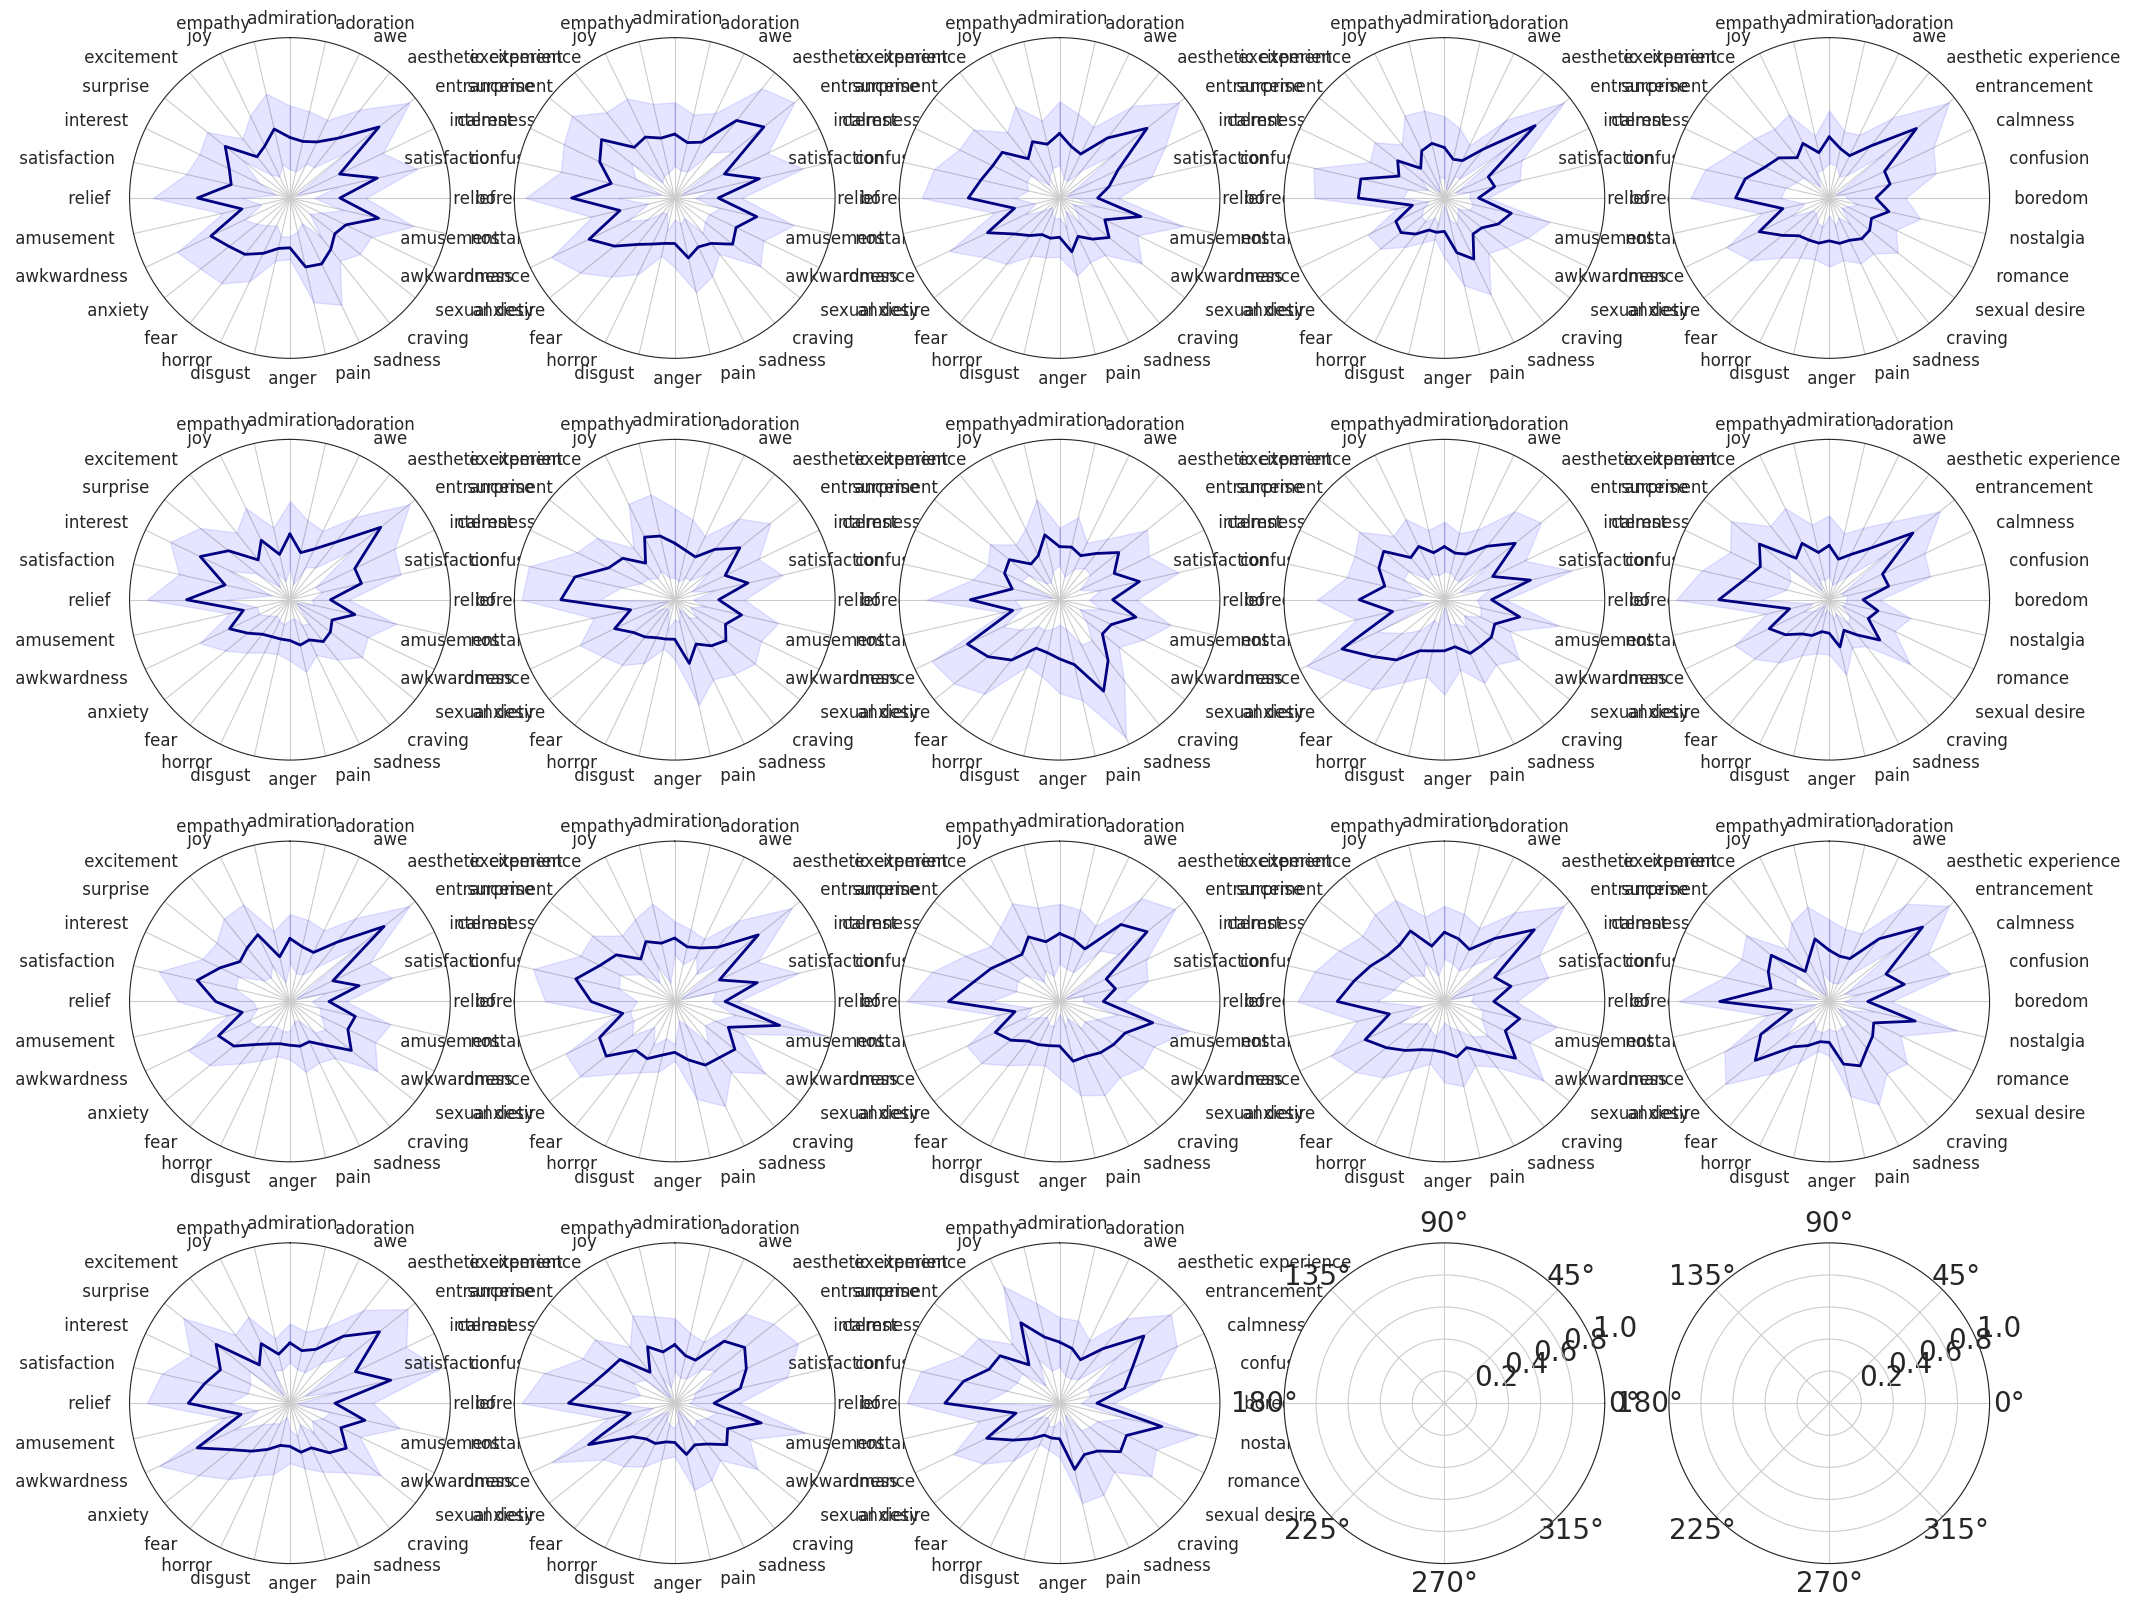

In [ ]:
labels = candidate_labels2.copy()
# Add a space before each label to add some padding
labels = [' ' + label for label in candidate_labels2.copy()]


fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (24,20), subplot_kw=dict(polar=True))
counter = 0
for ii in scores.keys():

    axi = ax.flat[counter]
    arr = np.nanmedian(scores[ii][:,newOrder], axis = 0).copy()
    std_arr = np.nanstd(scores[ii][:,newOrder], axis = 0).copy()
    # Number of variables
    num_vars = len(labels)

    # Compute angle for each axis in the plot
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is circular, so we need to "close the loop"
    arr = np.concatenate((arr, [arr[0]]))  # close the loop
    std_arr = np.concatenate((std_arr, [std_arr[0]]))  # close the loop
    angles += angles[:1]  # close the loop

    # Draw the outline of our data
    axi.plot(angles, arr, color='navy', alpha=1, lw = 2)
    # Fill region within std_arr
    axi.fill_between(angles, arr-std_arr, arr+std_arr, color='blue', alpha=0.1)

    # Fix axis to go in the right order and start at 12 o'clock
    axi.set_theta_offset(np.pi / 2)
    axi.set_theta_direction(-1)
    axi.set_rticks([])
    # Draw axis lines for each angle and label
    axi.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12)

    # Rotate labels
    for label, angle in zip(axi.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    counter += 1

#plt.savefig(basedir+'RadarPlot_AllSubjectsEmotions_12102023.svg', transparent = True)

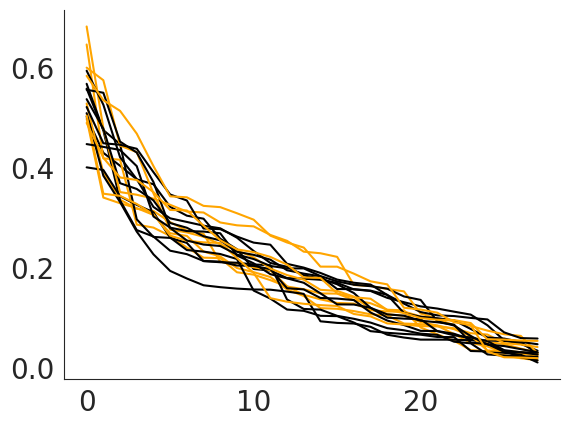

In [ ]:
import os
from natsort import natsorted
no_music = np.array(['ALEROMA', 'AURORA', 'DODO', 'FRESH', 'GIAC', 'LEONIE', 'LINUS', 'LUDO', 'MATT', 'MERIAM'])
file_path = natsorted(glob.glob('/content/drive/MyDrive/Laptop_Info/BreathWork/HR_Data/*.txt', recursive = True))

participants = np.array([os.path.splitext(os.path.basename(name))[0].replace(" DURING", "") for name in file_path])
music = participants[~np.in1d(participants, no_music)]
music_indices = np.where(~np.in1d(participants, no_music))[0]
no_music_indices = np.where(np.in1d(participants, no_music))[0]
counter = 0
for ii in scores.keys():
  if counter in no_music_indices:
      color_line = 'black'
  else:
      color_line = 'orange'
  #for jj in range(scores[ii].shape[0]):
  #  plt.plot(np.sort(scores[ii][jj,:])[::-1], color = color_line, alpha = 0.1)
  counter += 1

counter = 0
for ii in scores.keys():
  if counter in no_music_indices:
      color_line = 'black'
  else:
      color_line = 'orange'
  plt.plot(np.sort(np.nanmedian(scores[ii], axis = 0))[::-1], color = color_line, alpha = 1)
  counter += 1

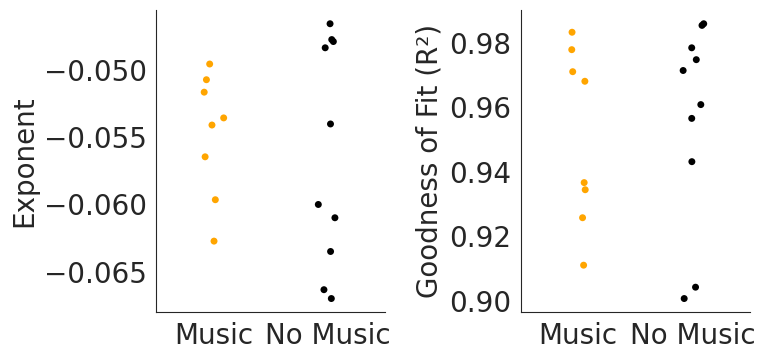

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Exponential function for fitting
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Initialize lists to save results
exponents_music = []
gof_music = []
exponents_noMusic = []
gof_noMusic = []

counter = 0
for ii in scores.keys():
    if counter in no_music_indices:
        sorted_values = np.sort(np.nanmean(scores[ii], axis=0))[::-1]
        x_data = np.arange(len(sorted_values))
        popt, pcov = curve_fit(exp_func, x_data, sorted_values, maxfev=10000)
        exponents_noMusic.append(popt[1])
        residuals = sorted_values - exp_func(x_data, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((sorted_values - np.mean(sorted_values))**2)
        r_squared = 1 - (ss_res / ss_tot)
        gof_noMusic.append(r_squared)
    else:
        sorted_values = np.sort(np.nanmean(scores[ii], axis=0))[::-1]
        x_data = np.arange(len(sorted_values))
        popt, pcov = curve_fit(exp_func, x_data, sorted_values, maxfev=10000)
        exponents_music.append(popt[1])
        residuals = sorted_values - exp_func(x_data, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((sorted_values - np.mean(sorted_values))**2)
        r_squared = 1 - (ss_res / ss_tot)
        gof_music.append(r_squared)

    counter += 1

# Convert to numpy arrays for convenience
exponents_music = np.array(exponents_music)
gof_music = np.array(gof_music)
exponents_noMusic = np.array(exponents_noMusic)
gof_noMusic = np.array(gof_noMusic)


# Plotting the results
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot exponents using stripplot
sns.stripplot(data=[exponents_music, exponents_noMusic], ax=axs[0], palette=["orange", "black"], jitter=True)
axs[0].set_ylabel('Exponent')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Music', 'No Music'])

# Plot goodness of fit using stripplot
sns.stripplot(data=[gof_music, gof_noMusic], ax=axs[1], palette=["orange", "black"], jitter=True)
axs[1].set_ylabel('Goodness of Fit (R²)')
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Music', 'No Music'])

plt.tight_layout()
plt.show()


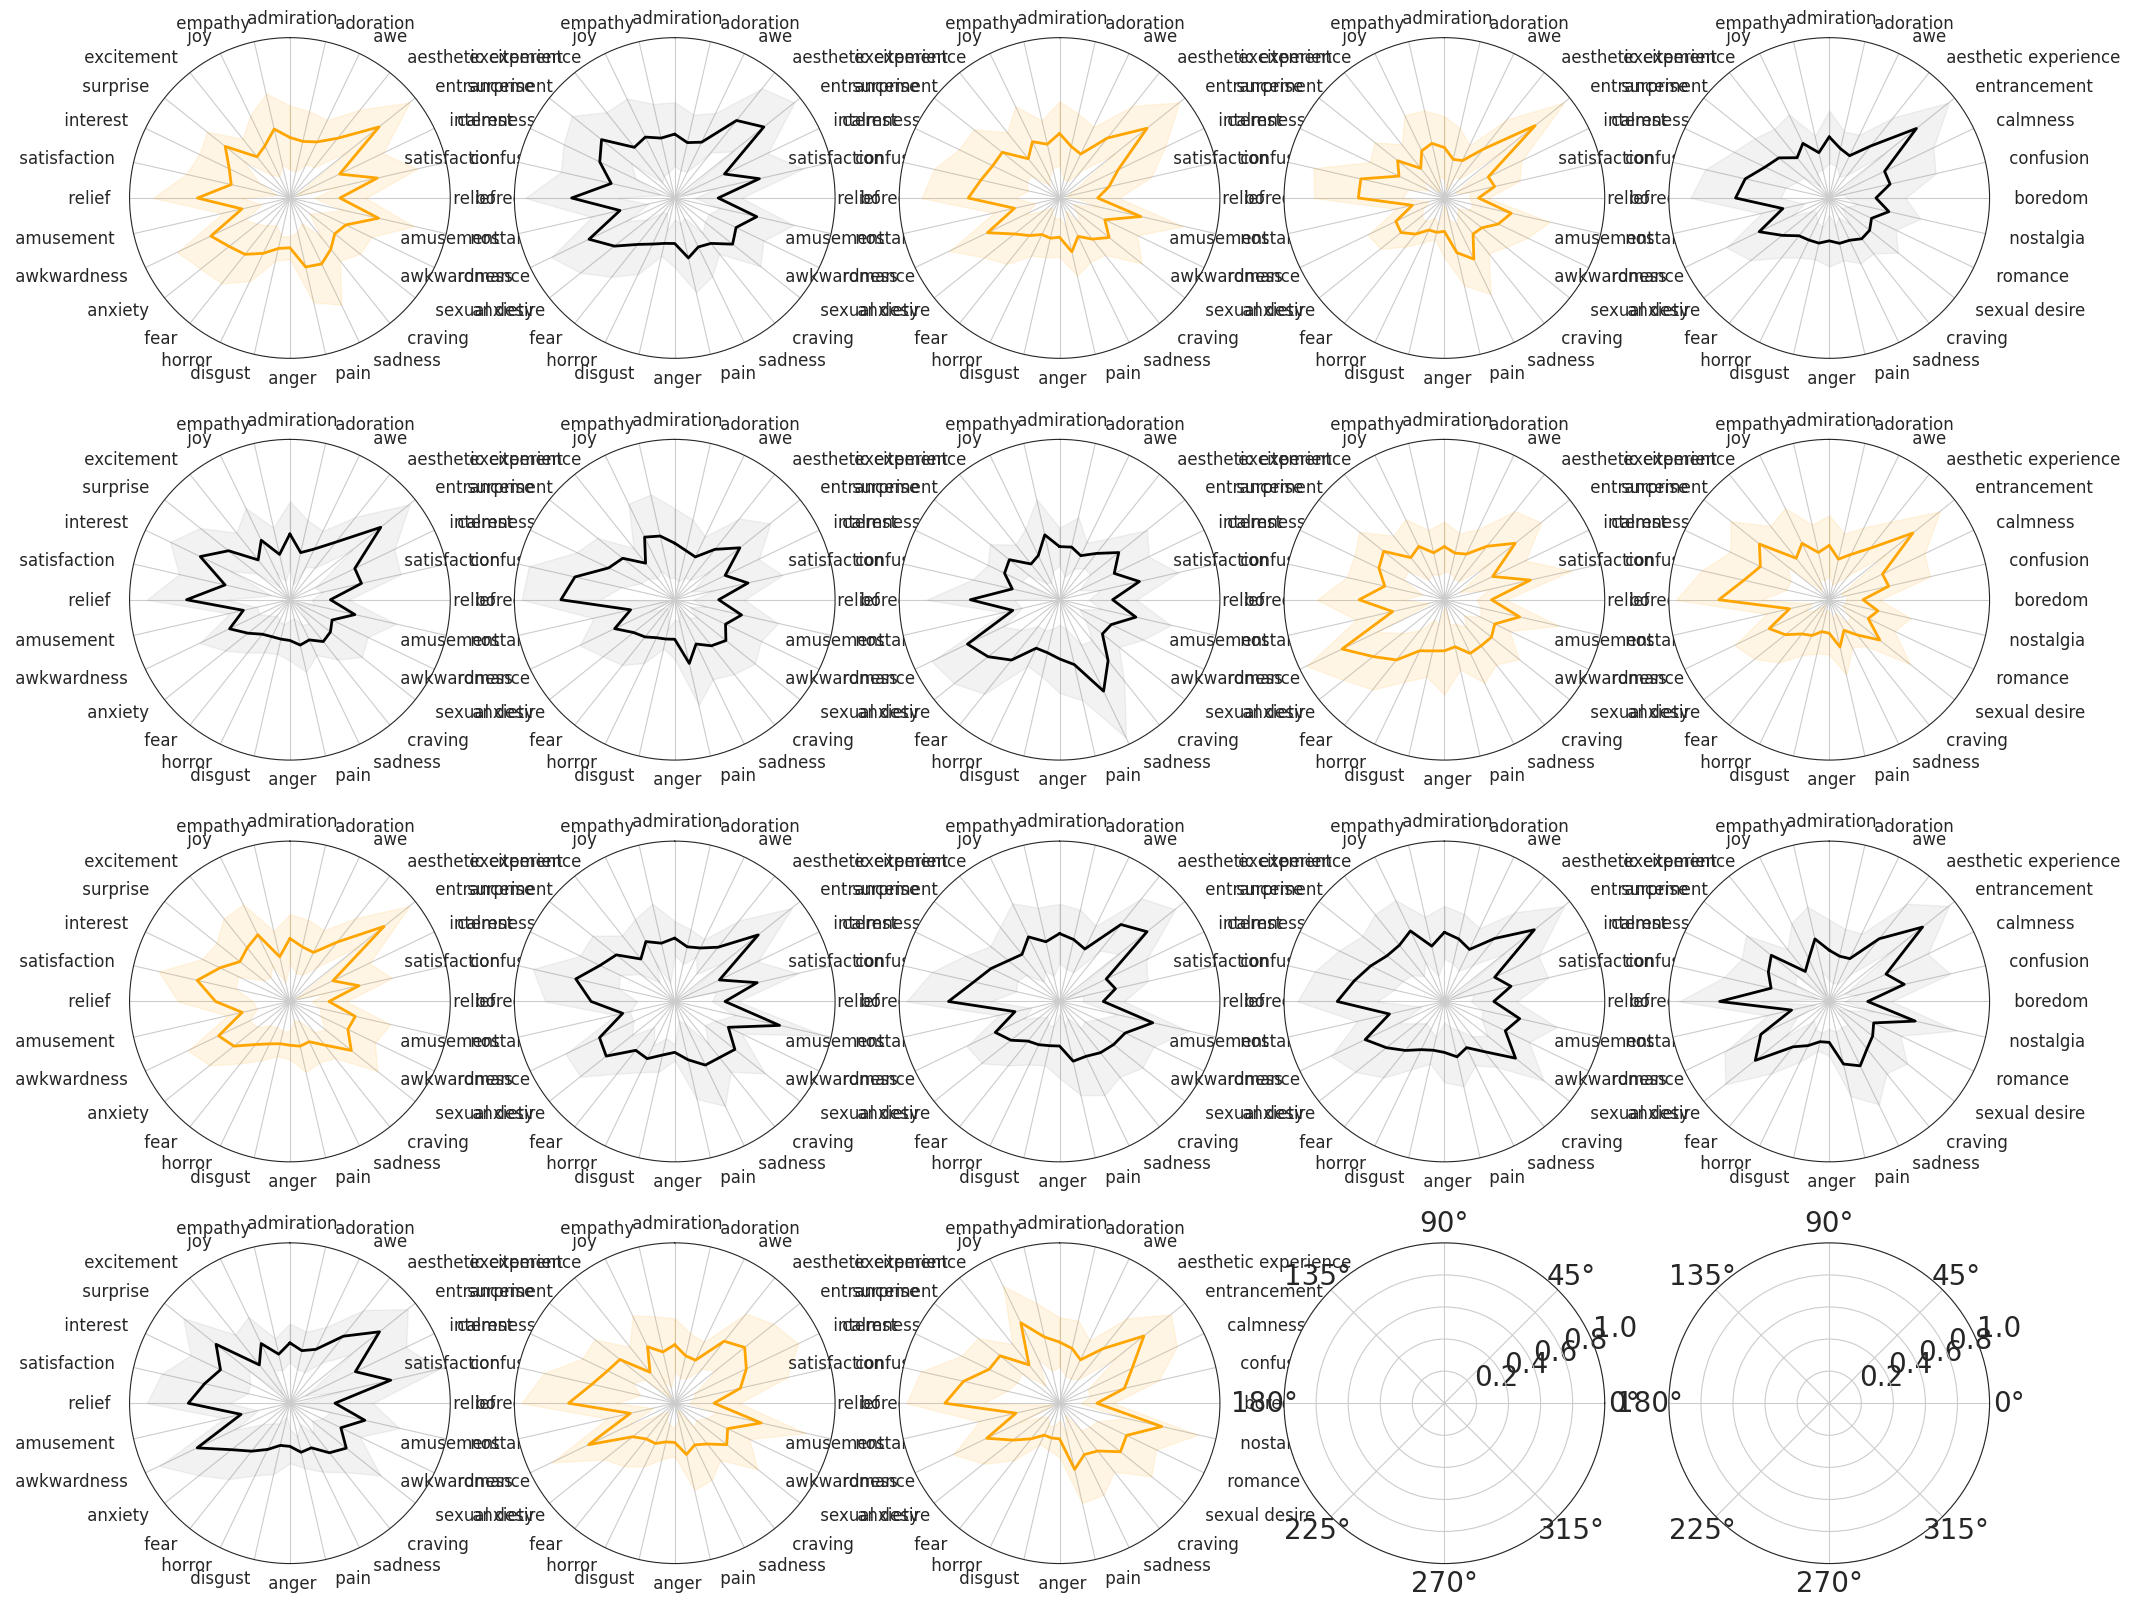

In [ ]:
labels = candidate_labels2.copy()
# Add a space before each label to add some padding
labels = [' ' + label for label in candidate_labels2.copy()]


fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (24,20), subplot_kw=dict(polar=True))
counter = 0

import os
from natsort import natsorted
no_music = np.array(['ALEROMA', 'AURORA', 'DODO', 'FRESH', 'GIAC', 'LEONIE', 'LINUS', 'LUDO', 'MATT', 'MERIAM'])
file_path = natsorted(glob.glob('/content/drive/MyDrive/Laptop_Info/BreathWork/HR_Data/*.txt', recursive = True))

participants = np.array([os.path.splitext(os.path.basename(name))[0].replace(" DURING", "") for name in file_path])
music = participants[~np.in1d(participants, no_music)]

music_indices = np.where(~np.in1d(participants, no_music))[0]
no_music_indices = np.where(np.in1d(participants, no_music))[0]


for ii in scores.keys():

    axi = ax.flat[counter]
    arr = np.nanmedian(scores[ii][:,newOrder], axis = 0).copy()
    std_arr = np.nanstd(scores[ii][:,newOrder], axis = 0).copy()
    # Number of variables
    num_vars = len(labels)

    # Compute angle for each axis in the plot
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is circular, so we need to "close the loop"
    arr = np.concatenate((arr, [arr[0]]))  # close the loop
    std_arr = np.concatenate((std_arr, [std_arr[0]]))  # close the loop
    angles += angles[:1]  # close the loop

    if counter in no_music_indices:
        color_line = 'black'
        color_shade = 'gray'
    else:
        color_line = 'orange'
        color_shade = 'orange'
    # Draw the outline of our data
    axi.plot(angles, arr, color=color_line, alpha=1, lw = 2)
    # Fill region within std_arr
    axi.fill_between(angles, arr-std_arr, arr+std_arr, color=color_shade, alpha=0.1)

    # Fix axis to go in the right order and start at 12 o'clock
    axi.set_theta_offset(np.pi / 2)
    axi.set_theta_direction(-1)
    axi.set_rticks([])
    # Draw axis lines for each angle and label
    axi.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12)

    # Rotate labels
    for label, angle in zip(axi.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    counter += 1

#plt.savefig(basedir+'RadarPlot_AllSubjectsEmotions_MusicNoMusic_31102023.svg', transparent = True)

In [ ]:
labels = candidate_labels2.copy()

music_indices = np.where(~np.in1d(participants, no_music))[0]
no_music_indices = np.where(np.in1d(participants, no_music))[0]
arr_music = np.full((len(music_indices), len(labels)), np.nan)
arr_noMusic = np.full((len(no_music_indices), len(labels)), np.nan)

counter_music = 0
counter_noMusic = 0
for ii, key in enumerate(scores.keys()):
    if ii in music_indices:
        arr_music[counter_music, :] = np.nanmedian(scores[key][:,newOrder], axis = 0).copy()
        counter_music += 1
    else:
        arr_noMusic[counter_noMusic, :] = np.nanmedian(scores[key][:,newOrder], axis = 0).copy()
        counter_noMusic += 1

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Combine data and create labels
n_group, n_emotions = arr_music.shape

# Flatten the matrices and create a DataFrame
data = np.concatenate([arr_music.flatten(), arr_noMusic.flatten()])
music_condition = np.array(['Music'] * n_group * n_emotions + ['NoMusic'] * n_group * n_emotions)
emotion_labels = np.tile(np.arange(n_emotions), n_group * 2)

df = pd.DataFrame({
    'Emotion': emotion_labels,
    'Music': music_condition,
    'Score': data
})
# Perform the two-way ANOVA
model = ols('Score ~ C(Emotion) * C(Music)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                       sum_sq     df          F         PR(>F)
C(Emotion)           6.331962   27.0  41.113814  1.665183e-103
C(Music)             0.012257    1.0   2.148894   1.433742e-01
C(Emotion):C(Music)  0.054109   27.0   0.351336   9.991356e-01
Residual             2.555435  448.0        NaN            NaN


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Define emotion categories
positive_emotions = np.array([
    'adoration', 'admiration', 'aesthetic experience', 'amusement', 'awe',
    'calmness', 'entrancement', 'excitement', 'joy', 'relief', 'satisfaction',
    'sexual desire'
])

neutral_emotions = np.array([
    'boredom', 'craving', 'empathy', 'interest', 'nostalgia', 'romance',
    'surprise'
])

negative_emotions = np.array([
    'anger', 'anxiety', 'awkwardness', 'confusion', 'disgust',
    'fear', 'horror', 'pain', 'sadness'
])

# Combine all emotions to ensure correct ordering
all_emotions = np.concatenate([positive_emotions, neutral_emotions, negative_emotions])
n_emotions = len(all_emotions)  # Should be 27 based on provided lists

# Verify that the number of emotions matches
if arr_music.shape[1] != n_emotions or arr_noMusic.shape[1] != n_emotions:
    raise ValueError("The number of emotions in the data does not match the defined categories.")

# Combine data and create labels
# Total observations: 2 conditions (Music, NoMusic) * n_group * n_emotions
data = np.concatenate([arr_music.flatten(), arr_noMusic.flatten()])
music_condition = np.array(['Music'] * (n_group * n_emotions) + ['NoMusic'] * (n_group * n_emotions))

# Create EmotionCategory labels
# First len(positive_emotions) are 'pos', next len(neutral_emotions) are 'neu', then 'neg'
emotion_categories = (
    ['Positive'] * len(positive_emotions) +
    ['Neutral'] * len(neutral_emotions) +
    ['Negative'] * len(negative_emotions)
)

# Ensure the mapping length matches the number of emotions
if len(emotion_categories) != n_emotions:
    raise ValueError("The total number of emotion categories does not match the number of emotions.")

# Create EmotionCategory array repeated for each group and condition
emotion_category = np.tile(emotion_categories, n_group * 2)

# Create the DataFrame
df = pd.DataFrame({
    'EmotionCategory': emotion_category,
    'Music': music_condition,
    'Score': data
})

# Perform the two-way ANOVA
model = ols('Score ~ C(EmotionCategory) * C(Music)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nTwo-Way ANOVA Results:")
print(anova_table)



Two-Way ANOVA Results:
                               sum_sq     df          F        PR(>F)
C(EmotionCategory)           1.057684    2.0  33.434381  2.372272e-14
C(Music)                     0.012257    1.0   0.774941  3.791174e-01
C(EmotionCategory):C(Music)  0.006797    2.0   0.214861  8.067287e-01
Residual                     7.877024  498.0        NaN           NaN


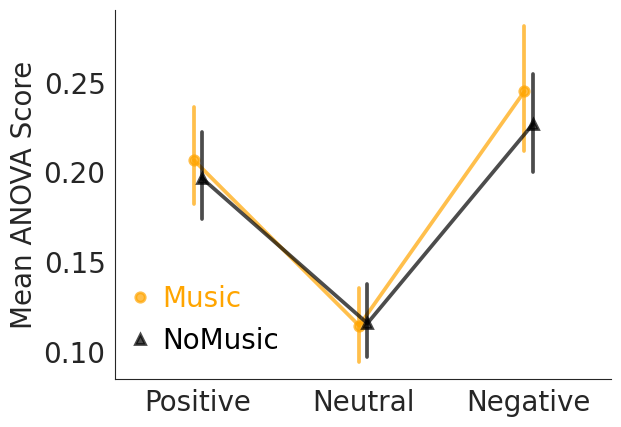

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pal = sns.color_palette(['orange', 'black'])

# Calculate means and confidence intervals
sns.pointplot(x='EmotionCategory', y='Score', hue='Music', data=df, dodge=True, errorbar=('ci', 95), palette = pal, alpha = 0.7, markers = ['o', '^'])

plt.ylabel('Mean ANOVA Score')
plt.legend(frameon = False, handlelength = 0, labelcolor = 'linecolor')
plt.xlabel('')
plt.savefig('ANOVA_scores_musicNomusic_31102024.svg', transparent = True)

Text(0.5, 0, 'Probability')

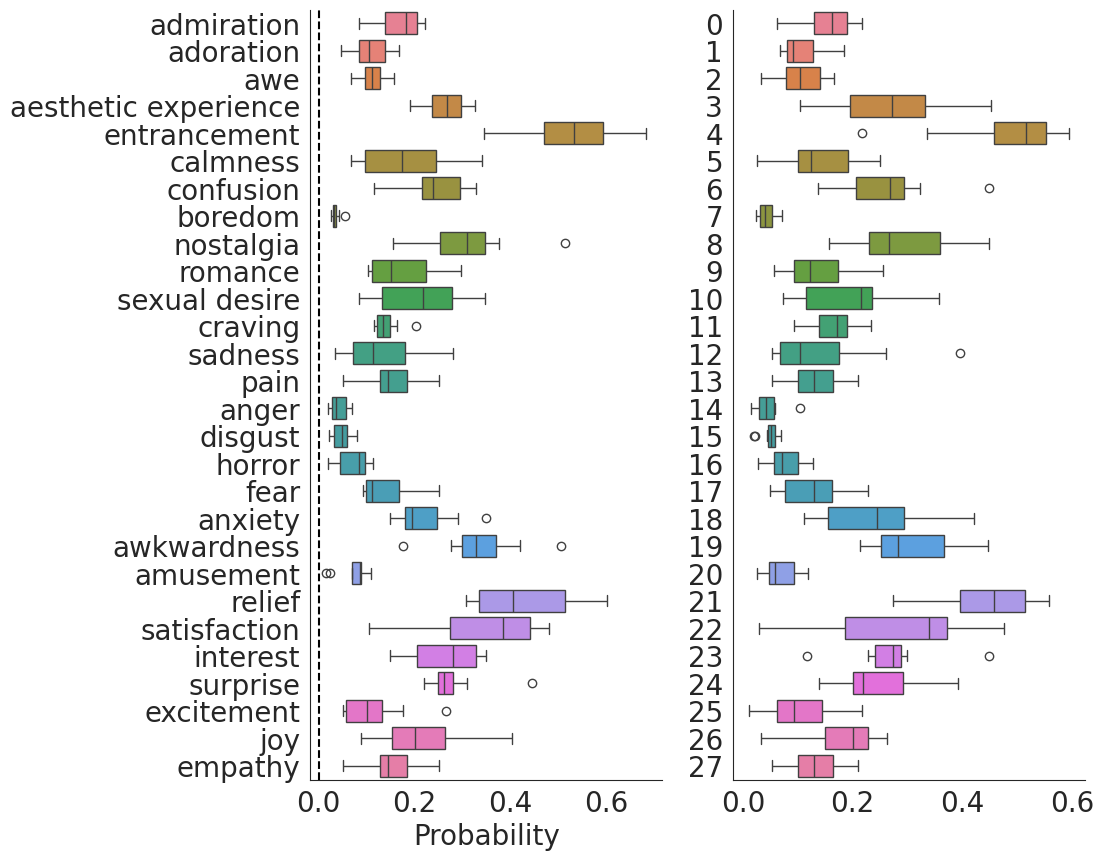

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 10))
music_indices = np.where(~np.in1d(participants, no_music))[0]
no_music_indices = np.where(np.in1d(participants, no_music))[0]
arr_music = np.full((len(music_indices), len(labels)), np.nan)
arr_noMusic = np.full((len(no_music_indices), len(labels)), np.nan)

counter_music = 0
counter_noMusic = 0
for ii, key in enumerate(scores.keys()):
    if ii in music_indices:
        arr_music[counter_music, :] = np.nanmedian(scores[key][:,newOrder], axis = 0).copy()
        counter_music += 1
    else:
        arr_noMusic[counter_noMusic, :] = np.nanmedian(scores[key][:,newOrder], axis = 0).copy()
        counter_noMusic += 1

#sns.boxplot(arr_music-arr_noMusic, ax = ax[0], orient = 'h')
sns.boxplot(arr_music, ax = ax[0], orient = 'h')
sns.boxplot(arr_noMusic, ax = ax[1], orient = 'h')
ax[0].axvline(0, ls = '--', color = 'black')
ax[0].set_yticks(ticks = np.arange(28), labels = candidate_labels2)
ax[0].set_xlabel('Probability')

In [ ]:
!pip install kneed
import kneed as kn
from scipy import stats as sts

probs_all = []
for ii in scores.keys():
    probs_all.append(scores[ii].ravel())
# Flatten a list of lists [of lists(of lists...)] of arbitrary depth
def flatten(l):
    for i in l:
        if isinstance(i,list):
            yield from flatten(i)
        else:
            yield i

probs_all_flat = np.array([item for sublist in list(flatten(probs_all)) for item in sublist])

probs_all_fin = probs_all_flat[~np.isnan(probs_all_flat)]
uniq = np.unique(probs_all_fin)
density = sts.gaussian_kde(probs_all_fin)
density = density(uniq)

max_idx = np.where(density == np.nanmax(density))[0][0]

knee = kn.KneeLocator(uniq[max_idx:], density[max_idx:], curve='convex', direction='decreasing', interp_method='interp1d')

In [ ]:
# Initialize lists
list_music = []
list_noMusic = []

# Iterate through the scores dictionary
for ii, (key, value) in enumerate(scores.items()):
    reordered_scores = value[:, newOrder]
    if ii in music_indices:
        list_music.append(reordered_scores)
    else:
        list_noMusic.append(reordered_scores)

# Concatenate the lists into arrays
arr_music = np.vstack(list_music)
arr_noMusic = np.vstack(list_noMusic)

arr_music[arr_music<knee.knee] = np.nan
arr_noMusic[arr_noMusic<knee.knee] = np.nan

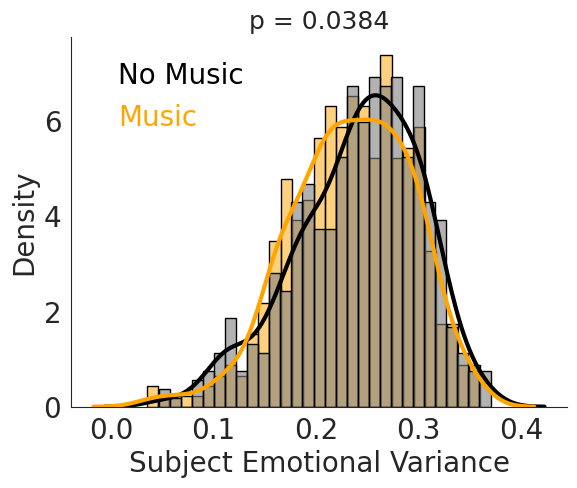

In [ ]:
from scipy.stats import mannwhitneyu as mu
arr1 = np.nanstd(arr_music, axis = 1)
arr2 = np.nanstd(arr_noMusic, axis = 1)
pval = mu(arr1, arr2).pvalue
# Plot the histograms with labels
sns.histplot(arr1, stat='density', bins=30, edgecolor='black', color='orange', alpha=0.5)
sns.histplot(arr2, stat='density', bins=30, edgecolor='black', color='gray', alpha=0.6)

# Overlay KDE plots with desired line width
sns.kdeplot(arr2, linewidth=3, label='No Music', color='black')
sns.kdeplot(arr1, linewidth=3, label='Music', color='orange')
plt.xlabel('Subject Emotional Variance')
plt.legend(frameon = False, labelcolor = 'linecolor', handlelength = 0)
plt.title('p = '+str(pval.round(4)), fontsize = 18)
plt.savefig(basedir+'MusicVariance_19062024.svg', transparent = True)

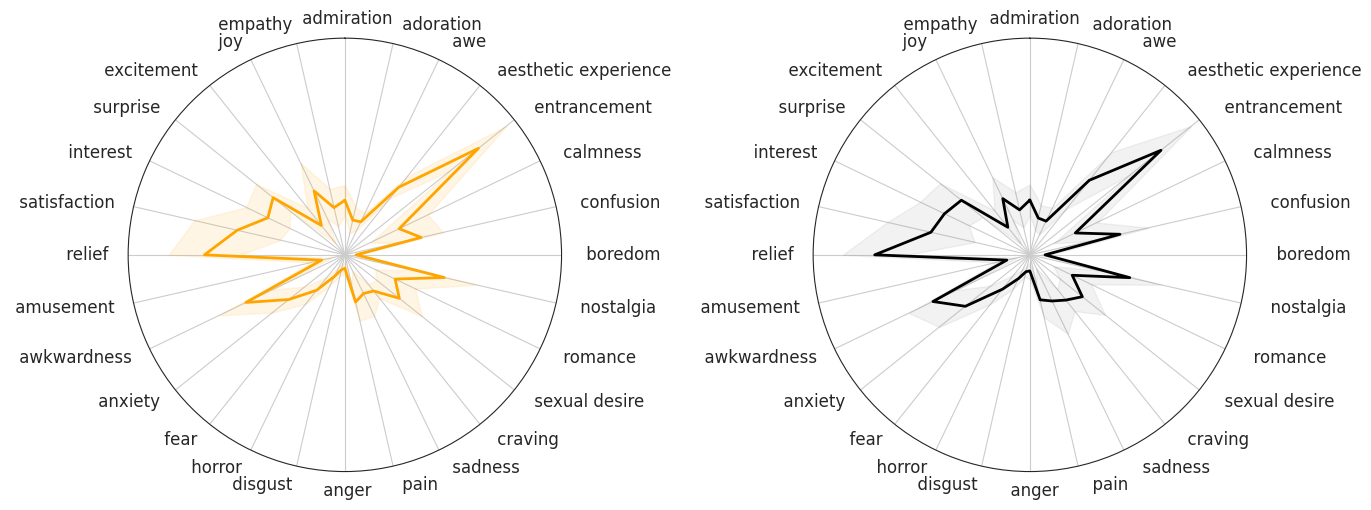

In [ ]:
labels = candidate_labels2.copy()

fig, ax = plt.subplots(ncols = 2, figsize = (14,7), subplot_kw=dict(polar=True))

music_indices = np.where(~np.in1d(participants, no_music))[0]
no_music_indices = np.where(np.in1d(participants, no_music))[0]
arr_music = np.full((len(music_indices), len(labels)), np.nan)
arr_noMusic = np.full((len(no_music_indices), len(labels)), np.nan)

counter_music = 0
counter_noMusic = 0
for ii, key in enumerate(scores.keys()):
    if ii in music_indices:
        arr_music[counter_music, :] = np.nanmedian(scores[key][:,newOrder], axis = 0).copy()
        counter_music += 1
    else:
        arr_noMusic[counter_noMusic, :] = np.nanmedian(scores[key][:,newOrder], axis = 0).copy()
        counter_noMusic += 1

# Number of variables
num_vars = len(labels)

# Draw the outline of our data
for (ii, axi, arr1) in zip(range(2), ax.flat, [arr_music, arr_noMusic]):

    # Compute angle for each axis in the plot
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    arr = np.nanmean(arr1, axis = 0)
    std_arr = np.nanstd(arr1, axis = 0)
    # The plot is circular, so we need to "close the loop"
    arr = np.concatenate((arr, [arr[0]]))  # close the loop
    std_arr = np.concatenate((std_arr, [std_arr[0]]))  # close the loop
    angles += angles[:1]  # close the loop

    if ii == 0:
        color_line = 'orange'
        color_shade = 'orange'
    else:
        color_line = 'black'
        color_shade = 'gray'
    axi.plot(angles, arr, color=color_line, alpha=1, lw = 2)
    # Fill region within std_arr
    axi.fill_between(angles, arr-std_arr, arr+std_arr, color=color_shade, alpha=0.1)

    # Fix axis to go in the right order and start at 12 o'clock
    axi.set_theta_offset(np.pi / 2)
    axi.set_theta_direction(-1)
    axi.set_rticks([])

    # Add a space before each label to add some padding
    labels = [' ' + label for label in labels]

    # Draw axis lines for each angle and label
    axi.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize = 12)

    # Rotate labels
    for label, angle in zip(axi.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
plt.tight_layout()

#plt.savefig(basedir+'RadarPlot_MeanSubjectEmotions_12102023.pdf', transparent = True)

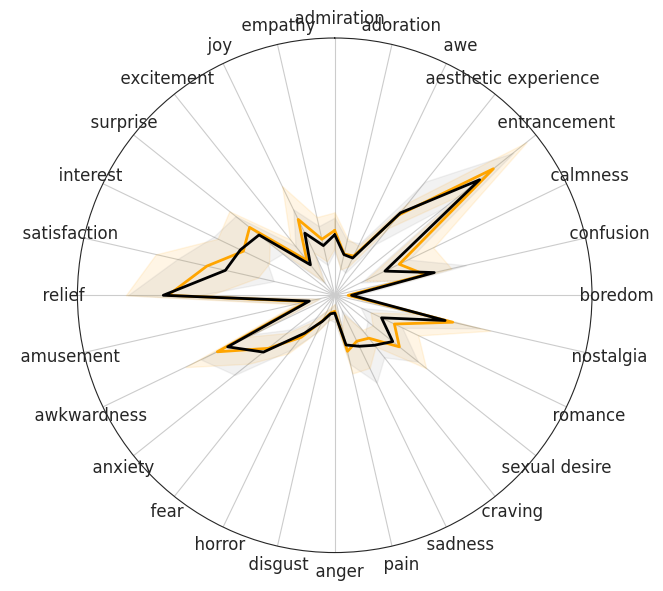

In [ ]:
labels = candidate_labels2.copy()

fig, ax = plt.subplots(ncols = 1, figsize = (7,7), subplot_kw=dict(polar=True))

music_indices = np.where(~np.in1d(participants, no_music))[0]
no_music_indices = np.where(np.in1d(participants, no_music))[0]
arr_music = np.full((len(music_indices), len(labels)), np.nan)
arr_noMusic = np.full((len(no_music_indices), len(labels)), np.nan)

counter_music = 0
counter_noMusic = 0
for ii, key in enumerate(scores.keys()):
    if ii in music_indices:
        arr_music[counter_music, :] = np.nanmedian(scores[key][:,newOrder], axis = 0).copy()
        counter_music += 1
    else:
        arr_noMusic[counter_noMusic, :] = np.nanmedian(scores[key][:,newOrder], axis = 0).copy()
        counter_noMusic += 1

# Number of variables
num_vars = len(labels)

# Draw the outline of our data
for (ii, arr1) in zip(range(2), [arr_music, arr_noMusic]):

    # Compute angle for each axis in the plot
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    arr = np.nanmean(arr1, axis = 0)
    std_arr = np.nanstd(arr1, axis = 0)
    # The plot is circular, so we need to "close the loop"
    arr = np.concatenate((arr, [arr[0]]))  # close the loop
    std_arr = np.concatenate((std_arr, [std_arr[0]]))  # close the loop
    angles += angles[:1]  # close the loop

    if ii == 0:
        color_line = 'orange'
        color_shade = 'orange'
    else:
        color_line = 'black'
        color_shade = 'gray'
    ax.plot(angles, arr, color=color_line, alpha=1, lw = 2)
    # Fill region within std_arr
    ax.fill_between(angles, arr-std_arr, arr+std_arr, color=color_shade, alpha=0.1)

    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rticks([])

    # Add a space before each label to add some padding
    labels = [' ' + label for label in labels]

    # Draw axis lines for each angle and label
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize = 12)

    # Rotate labels
    for label, angle in zip(axi.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
plt.tight_layout()

#plt.savefig(basedir+'RadarPlot_MeanSubjectEmotions_MusicNoMusic_31102023.pdf', transparent = True)

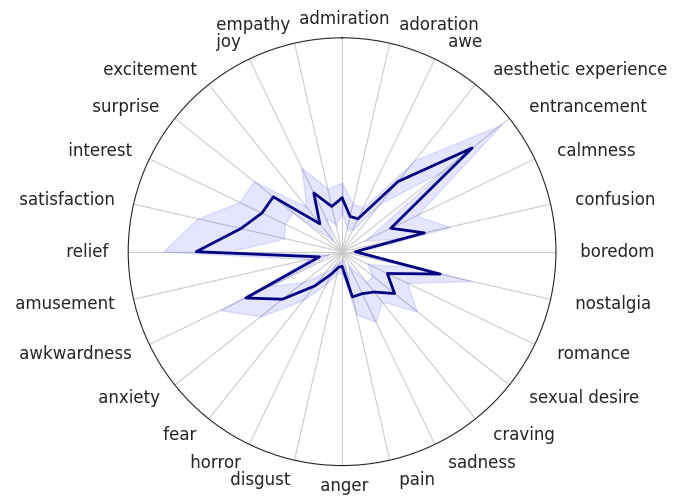

In [ ]:
labels = candidate_labels2.copy()

fig, axi = plt.subplots(figsize = (7,7), subplot_kw=dict(polar=True))

arr_fin = np.full((len(scores), len(labels)), np.nan)

for ii, key in enumerate(scores.keys()):

    arr_fin[ii, :] = np.nanmedian(scores[key][:,newOrder], axis = 0).copy()

# Number of variables
num_vars = len(labels)

# Compute angle for each axis in the plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
arr = np.nanmean(arr_fin, axis = 0)
std_arr = np.nanstd(arr_fin, axis = 0)
# The plot is circular, so we need to "close the loop"
arr = np.concatenate((arr, [arr[0]]))  # close the loop
std_arr = np.concatenate((std_arr, [std_arr[0]]))  # close the loop
angles += angles[:1]  # close the loop

# Draw the outline of our data
axi.plot(angles, arr, color='navy', alpha=1, lw = 2)
# Fill region within std_arr
axi.fill_between(angles, arr-std_arr, arr+std_arr, color='blue', alpha=0.1)

# Fix axis to go in the right order and start at 12 o'clock
axi.set_theta_offset(np.pi / 2)
axi.set_theta_direction(-1)
axi.set_rticks([])

# Add a space before each label to add some padding
labels = [' ' + label for label in labels]

# Draw axis lines for each angle and label
axi.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize = 12)

# Rotate labels
for label, angle in zip(axi.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')
plt.tight_layout()

plt.savefig(basedir+'RadarPlot_MeanSubjectEmotions_12102023.pdf', transparent = True)

In [ ]:
!pip install kneed
import kneed as kn
from scipy import stats as sts
from scipy.signal import find_peaks


probs_all = []
for ii in scores.keys():
    probs_all.append(scores[ii].ravel())
# Flatten a list of lists [of lists(of lists...)] of arbitrary depth
def flatten(l):
    for i in l:
        if isinstance(i,list):
            yield from flatten(i)
        else:
            yield i

probs_all_flat = np.array([item for sublist in list(flatten(probs_all)) for item in sublist])

probs_all_fin = probs_all_flat[~np.isnan(probs_all_flat)]
uniq = np.unique(probs_all_fin)
density = sts.gaussian_kde(probs_all_fin)
density = density(uniq)

max_idx = np.where(density == np.nanmax(density))[0][0]
# max_idx = np.searchsorted(uniq, uniq[max_idx1])

knee = kn.KneeLocator(uniq[max_idx:], density[max_idx:], curve='convex', direction='decreasing', interp_method='interp1d')
print(knee.knee)
"""
sns.histplot(probs_all_fin, kde = False, stat = 'density', fill = True, element = 'step', color = 'gray', alpha = 0.2, lw = 3, bins = 500)
plt.axvline(knee.knee, ls = '--', color = 'orange', lw = 3)
plt.xlim([-0.0025, 0.2])
plt.xlabel('Emotion probability', fontsize = 16)
plt.xticks([0, 0.1, 0.2], ['0', '0.1', '0.2'], fontsize = 16)
plt.yticks([])
plt.ylabel('')
sns.despine(left = True)
#plt.savefig(basedir+'PooledProbs_Distribution_Cutoff_25042023.svg', transparent = True)"""

0.03330965340137482


"\nsns.histplot(probs_all_fin, kde = False, stat = 'density', fill = True, element = 'step', color = 'gray', alpha = 0.2, lw = 3, bins = 500)\nplt.axvline(knee.knee, ls = '--', color = 'orange', lw = 3)\nplt.xlim([-0.0025, 0.2])\nplt.xlabel('Emotion probability', fontsize = 16)\nplt.xticks([0, 0.1, 0.2], ['0', '0.1', '0.2'], fontsize = 16)\nplt.yticks([])\nplt.ylabel('')\nsns.despine(left = True)\n#plt.savefig(basedir+'PooledProbs_Distribution_Cutoff_25042023.svg', transparent = True)"

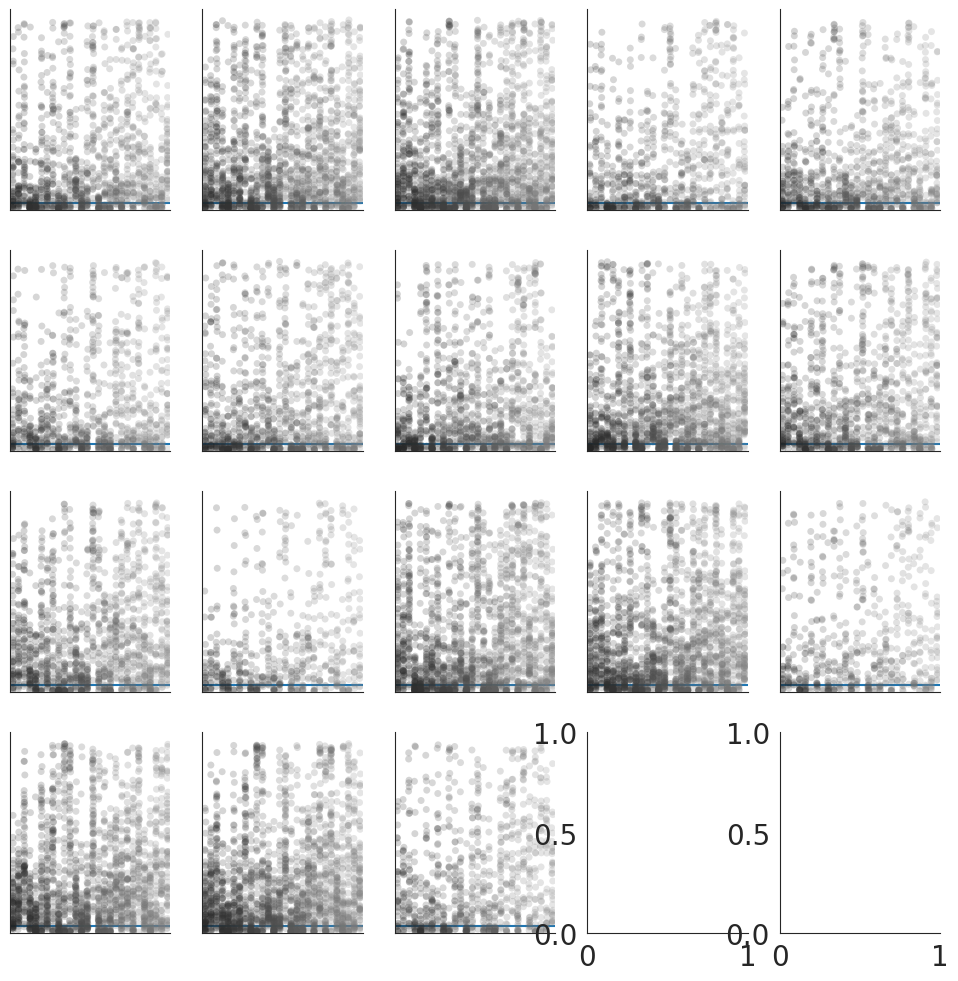

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 6, figsize = (24, 12))

for ii, key in enumerate(scores.keys()):
    axi = ax.flat[ii]
    sns.stripplot(data = scores[key], palette = 'dark:gray', alpha = 0.2, ax = axi)
    axi.set_ylim([-0.005, 1.05])
    axi.axhline(knee.knee)
    axi.set_xticks([])
    axi.set_yticks([])
sns.despine()

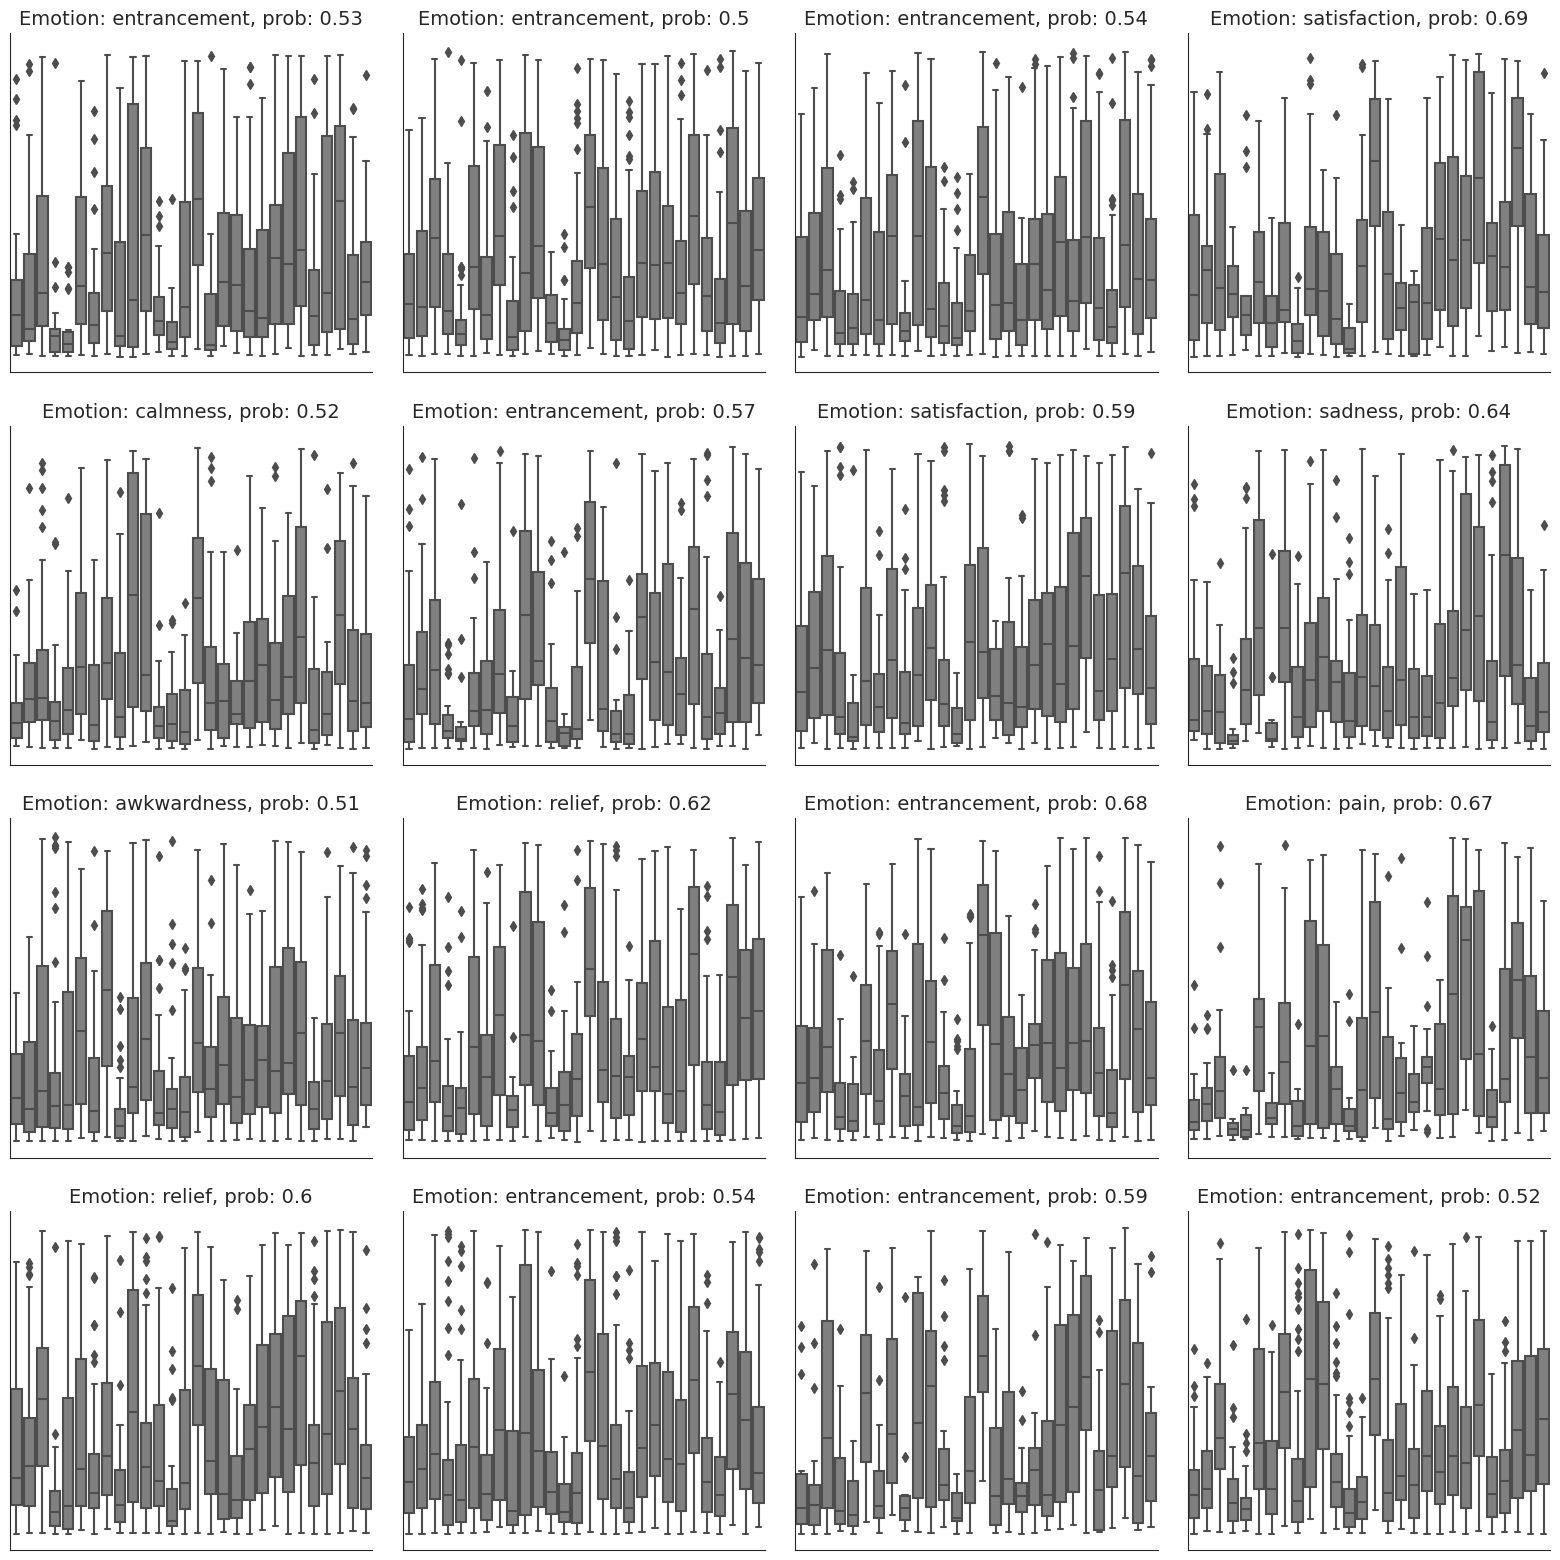

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')

dominant_emotion = []
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))

for ii, key in enumerate(scores.keys()):
    axi = ax.flat[ii]
    newScores = scores[key].copy()
    newScores[newScores<knee.knee] = np.nan
    medians = np.nanmedian(newScores, axis = 0)
    dominant_emotion.append(candidate_labels[np.where(medians == np.nanmax(medians))[0][0]])
    axi.set_title('Emotion: '+candidate_labels[np.where(medians == np.nanmax(medians))[0][0]]+', prob: '+str(np.round(np.nanmax(medians),2)), fontsize = 14)
    sns.boxplot(data = newScores, color = 'gray', ax = axi)
    axi.set_ylim([knee.knee - 0.05, 1.05])
    axi.set_xticks([])
    axi.set_yticks([])
sns.despine()
plt.tight_layout()

In [ ]:
from numpy.polynomial import Polynomial as P
def computeSlopes(vec_y, vec_x):

    new_y = vec_y[~np.isnan(vec_y)]
    new_x = vec_x[~np.isnan(vec_y)]

    x = np.array([new_x[0], new_x[-1]])
    y = np.array([new_y[0], new_y[-1]])
    coefs = [y[0], np.nan]

    if np.logical_and(np.nansum(np.abs(np.diff(x))) > 1e-5, np.nansum(np.abs(np.diff(y))) > 1e-5):
        model = P.fit(new_x, new_y, 1)
        coefs = model.convert().coef

    return coefs[1]

In [ ]:
def sum_sameValence_emotions(summedProbs):

    positive_emotions = np.array(['adoration', 'admiration', 'aesthetic experience', 'amusement', 'awe', 'calmness', 'entrancement', 'excitement', 'joy', 'relief', 'satisfaction', 'sexual desire'])
    neutral_emotions = np.array(['boredom', 'craving', 'empathy', 'interest', 'nostalgia', 'romance', 'surprise'])
    negative_emotions = np.array(['anger', 'anxiety', 'awkwardness', 'confusion', 'disgust', 'fear', 'horror', 'sadness'])

    valence_template = np.full(len(candidate_labels), np.nan)
    valence_template[np.isin(candidate_labels, positive_emotions)] = 2
    valence_template[np.isin(candidate_labels, neutral_emotions)] = 1
    valence_template[np.isin(candidate_labels, negative_emotions)] = 0

    scores_neg = np.nansum(summedProbs[valence_template == 0])/len(negative_emotions)
    scores_neu = np.nansum(summedProbs[valence_template == 1])/len(neutral_emotions)
    scores_pos = np.nansum(summedProbs[valence_template == 2])/len(positive_emotions)

    return scores_neg, scores_neu, scores_pos

In [ ]:
def sum_NewEmotionalAxis(summedProbs):

    # axis_awe = np.array(['aesthetic experience', 'awe', 'entrancement'])
    # axis_joy = np.array(['joy', 'excitement', 'surprise', 'interest', 'satisfaction'])
    # axis_fear = np.array(['anger', 'anxiety', 'awkwardness', 'confusion', 'disgust', 'fear', 'horror', 'sadness'])

    axis_entrancement = np.array(['aesthetic experience', 'entrancement', 'calmness'])
    axis_relief = np.array(['relief', 'surprise', 'interest', 'satisfaction'])
    axis_awkwardness = np.array(['anxiety', 'awkwardness', 'fear'])
    #axis_samsara = np.array(['sexual desire', 'craving', 'sadness', 'pain'])
    axis_samsara = np.array(['sexual desire', 'craving', 'sadness', 'pain', 'romance', 'nostalgia'])
    axis_rest = np.array(['admiration', 'adoration', 'awe', 'confusion', 'boredom', 'anger', 'disgust', 'horror',
                         'amusement', 'excitement', 'joy', 'empathy'])
    #axis_rest = np.array(['admiration', 'adoration', 'awe', 'confusion', 'boredom', 'nostalgia',
    #                'romance', 'sexual desire', 'craving', 'sadness', 'pain', 'anger', 'disgust', 'horror',
    #                     'amusement', 'excitement', 'joy', 'empathy'])

    valence_template = np.full(len(candidate_labels), np.nan)
    valence_template[np.isin(candidate_labels, axis_rest)] = 4
    valence_template[np.isin(candidate_labels, axis_samsara)] = 3
    valence_template[np.isin(candidate_labels, axis_entrancement)] = 2
    valence_template[np.isin(candidate_labels, axis_relief)] = 1
    valence_template[np.isin(candidate_labels, axis_awkwardness)] = 0

    scores_awkwardness = np.nansum(summedProbs[valence_template == 0])/len(axis_awkwardness)
    scores_relief = np.nansum(summedProbs[valence_template == 1])/len(axis_relief)
    scores_entrancement = np.nansum(summedProbs[valence_template == 2])/len(axis_entrancement)
    scores_samsara = np.nansum(summedProbs[valence_template == 3])/len(axis_samsara)
    scores_rest = np.nansum(summedProbs[valence_template == 4])/len(axis_rest)


    return scores_awkwardness, scores_relief, scores_entrancement, scores_samsara, scores_rest

In [ ]:
scores_neg = np.zeros(len(scores))
scores_neu = np.zeros(len(scores))
scores_pos = np.zeros(len(scores))

scores_awkwardness = np.zeros(len(scores))
scores_relief = np.zeros(len(scores))
scores_entrancement = np.zeros(len(scores))
scores_samsara = np.zeros(len(scores))
scores_rest = np.zeros(len(scores))

for ii, key in enumerate(scores.keys()):
    newScores = scores[key].copy()
    newScores[newScores<knee.knee] = np.nan
    medians = np.nanmedian(newScores, axis = 0)
    agg = np.nanmean(newScores, axis = 0)
    # valence[ii] = count_top_emotions(medians, np.array(candidate_labels), np.nanpercentile(medians, 50))
    scores_neg[ii], scores_neu[ii], scores_pos[ii] = sum_sameValence_emotions(agg)
    scores_awkwardness[ii], scores_relief[ii], scores_entrancement[ii], scores_samsara[ii], scores_rest[ii] = sum_NewEmotionalAxis(agg)


In [ ]:
from scipy.stats import mannwhitneyu

mannwhitneyu((scores_pos - scores_neg)/(scores_pos + scores_neg), np.zeros_like(scores_neg))

MannwhitneyuResult(statistic=288.0, pvalue=2.1947729656292626e-05)

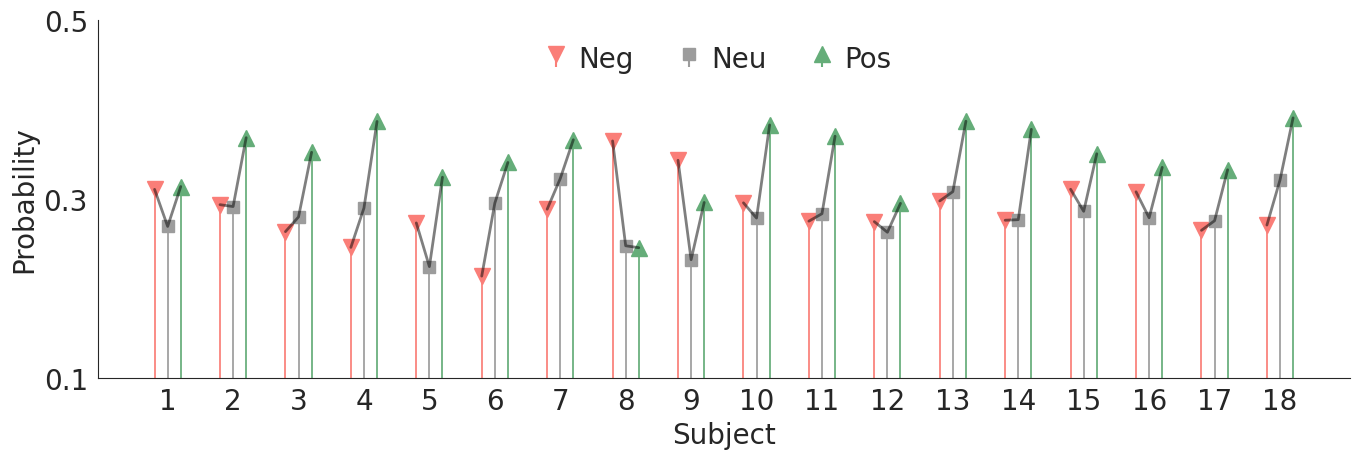

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grouped_lollipops(array1, array2, array3):
    plt.subplots(figsize=(14, 5))
    n_subjects = len(array1)

    # Set the width of the bars and the spacing between the groups
    bar_width = 1
    group_spacing = 2.0

    # Compute the positions for each bar group
    index_array1 = np.arange(n_subjects) * (bar_width * 3 + group_spacing)
    index_array2 = index_array1 + bar_width
    index_array3 = index_array1 + bar_width * 2

    # Plot the lollipops
    markerline, stemline, baseline, = plt.stem(index_array1, array1, label='Neg', linefmt='#FA7E78', markerfmt='v', basefmt=' ')
    plt.setp(stemline, linewidth = 1.25)
    plt.setp(markerline, markersize = 12)
    markerline, stemline, baseline, = plt.stem(index_array2, array2, label='Neu', linefmt='#9c9c9c', markerfmt='s', basefmt=' ')
    plt.setp(stemline, linewidth = 1.25)
    plt.setp(markerline, markersize = 8)
    markerline, stemline, baseline, = plt.stem(index_array3, array3, label='Pos', linefmt='#65AD79', markerfmt='^', basefmt=' ')
    plt.setp(stemline, linewidth = 1.25)
    plt.setp(markerline, markersize = 12)

    # Customize marker colors
    plt.setp(plt.gca().get_lines()[::3], color='#FA7E78')
    plt.setp(plt.gca().get_lines()[1::3], color='#65AD79')
    plt.setp(plt.gca().get_lines()[2::3], color='#9c9c9c')

    # Connect the dots
    for ii in range(len(index_array1)):
        plt.plot([index_array1[ii], index_array2[ii], index_array3[ii]], [array1[ii], array2[ii], array3[ii]], color='black', alpha=0.5, lw=2)

    # Set the x-axis labels for each group
    plt.xticks(index_array1 + bar_width, np.arange(1, n_subjects + 1))

    # Add legend and labels
    plt.xlabel('Subject')
    plt.ylabel('Probability')
    plt.ylim([0.1, 0.5])
    plt.legend(frameon=False, handlelength=0, labelcolor='linecolor', ncol=3, loc='upper center')
    plt.yticks([0.1, 0.3, 0.5])
    plt.tight_layout()

plot_grouped_lollipops(scores_neg, scores_neu, scores_pos)
plt.savefig(basedir+'EmotionalContent_PerParticipant_03112024.svg', transparent = True)

In [ ]:
def signifStars(x1, x2, scale, v, ax, p, printP = False, fontsiz = 16):
    # y, col = scale*np.max(v), 'k'
    ax.plot([scale, scale], [x1, x2], lw=1.5, c='k')
    siz = fontsiz
    if np.logical_and(p > 0.5, p<1):
        p = 1-p
    if p < 0.001:
        stringy = '*\n*\n*'
    elif p < 0.01:
        stringy = '**'
    elif p < 0.05:
        stringy = '*'
    elif p > 0.05:
        if printP == False:
            stringy = 'ns'
        else:
            stringy = str(np.round(p,3))
    if ~np.isnan(np.percentile(np.abs(v),99)):
        ax.text(scale, (x1+x2)*.5, stringy, ha='center', va='bottom', color='k', size = siz)

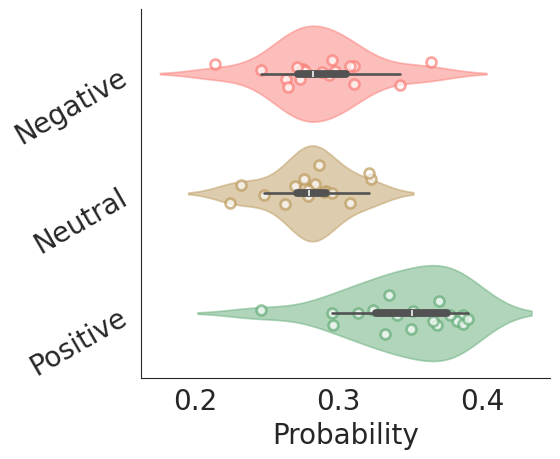

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

colors = ['#FA7E78', '#BD9B5E', '#65AD79']
fig, ax = plt.subplots(figsize=(6, 5))
data1 = [scores_neg, scores_neu, scores_pos]

violins = sns.violinplot(data=data1, orient='h', palette=colors, ax=ax)

for i in range(len(data1)):
    myviolin = ax.collections[i]
    color = colors[i]
    myviolin.set_facecolor(color)
    myviolin.set_edgecolor(color)
    myviolin.set_alpha(0.5)

    # Add scatterplot points with jitter
    y = data1[i]
    x = np.random.normal(i, 0.1, size=len(y))  # add jitter to x position
    ax.scatter(y, x, facecolor='white', edgecolor=color, s=50, linewidth=2, alpha=0.7)

plt.yticks(ticks=np.arange(0, len(data1)), labels=['Negative', 'Neutral', 'Positive'], rotation=30)
plt.xticks(ticks=np.linspace(0.2, 0.4, 3))
plt.xlabel('Probability')
sns.despine()
plt.tight_layout()
plt.show()

#plt.savefig(basedir+'Emotional_Content_Violinplots_12102023.pdf', transparent = True)

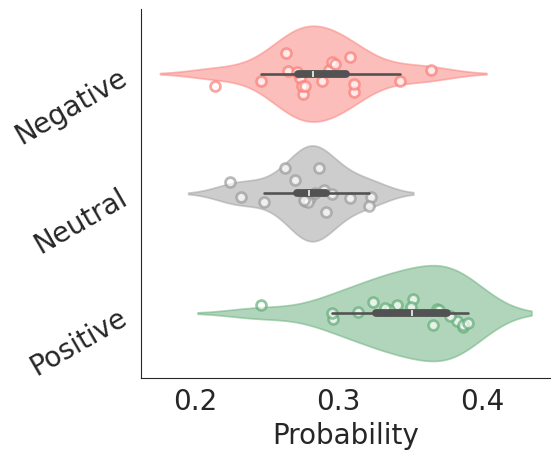

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

colors = ['#FA7E78', '#9c9c9c', '#65AD79']
fig, ax = plt.subplots(figsize=(6, 5))
data1 = [scores_neg, scores_neu, scores_pos]

violins = sns.violinplot(data=data1, orient='h', palette=colors, ax=ax)

for i in range(len(data1)):
    myviolin = ax.collections[i]
    color = colors[i]
    myviolin.set_facecolor(color)
    myviolin.set_edgecolor(color)
    myviolin.set_alpha(0.5)

    # Add scatterplot points with jitter
    y = data1[i]
    x = np.random.normal(i, 0.1, size=len(y))  # add jitter to x position
    ax.scatter(y, x, facecolor='white', edgecolor=color, s=50, linewidth=2, alpha=0.7)

plt.yticks(ticks=np.arange(0, len(data1)), labels=['Negative', 'Neutral', 'Positive'], rotation=30)
plt.xticks(ticks=np.linspace(0.2, 0.4, 3))
plt.xlabel('Probability')
sns.despine()

"""pairs_to_compare = [(0, 1), (1, 2), (0, 2)]
for x1, x2 in pairs_to_compare:
    _, p_value = mannwhitneyu(data1[x1], data1[x2], alternative='two-sided')
    print(p_value)
    if (x1 == 0)*(x2 == 2):
       signifStars(x1+0.125, x2+0.125, 1.2*max(np.max(data1[x1]), np.max(data1[x2])), 0.8, ax, p_value, printP=False)
    else:
      signifStars(x1+0.125, x2+0.125, 1.1*max(np.max(data1[x1]), np.max(data1[x2])), 0.8, ax, p_value, printP=False)
"""
plt.tight_layout()
plt.savefig(basedir+'Emotional_Content_Violinplots_03112024.svg', transparent = True)

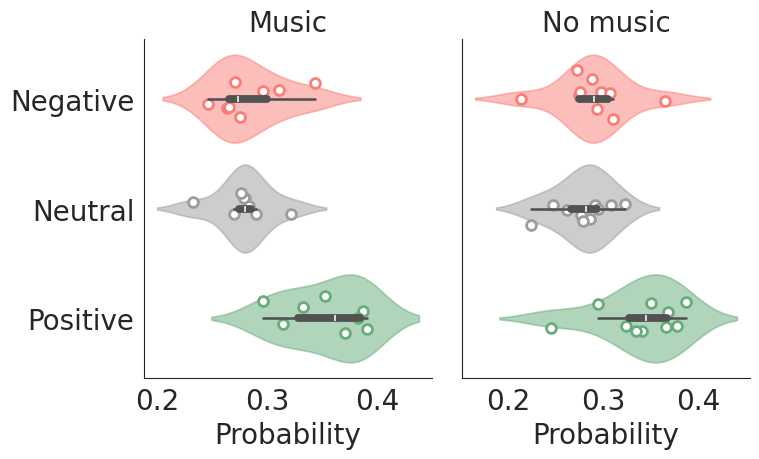

In [ ]:
#colors =  ['#FA7E78', '#BD9B5E', '#65AD79']
colors =  ['#FA7E78', '#9c9c9c', '#65AD79']
fig, ax = plt.subplots(ncols = 2, figsize = (8,5))
titls = ['Music', 'No music']
# Draw the outline of our data
for (ii, idx) in enumerate([music_indices, no_music_indices]):
    scor_neg = []
    scor_neu = []
    scor_pos = []
    for jj in range(len(scores)):
        if jj in idx:
            scor_neg.append(scores_neg[jj])
            scor_neu.append(scores_neu[jj])
            scor_pos.append(scores_pos[jj])

    data1 = [scor_neg, scor_neu, scor_pos]

    violins = sns.violinplot(data=data1, orient='h', palette=colors, ax=ax[ii])

    for i in range(len(data1)):
        myviolin = ax[ii].collections[i]
        color = colors[i]
        myviolin.set_facecolor(color)
        myviolin.set_edgecolor(color)
        myviolin.set_alpha(0.5)
        # Now color the scatterplot points manually using the same color as the corresponding violinplot
        y = data1[i]
        x = np.random.normal(i, 0.1, size=len(y)) # add jitter to x position
        ax[ii].scatter(y,x, facecolor='white', edgecolor = color, s=50, linewidth = 2)

    ax[ii].set_yticks(ticks=np.arange(0, len(data1)), labels=['Negative', 'Neutral', 'Positive'] if ii == 0 else [], rotation=0)


    ax[ii].set_xticks(ticks=np.linspace(0.2, 0.4, 3))
    ax[ii].set_xlabel('Probability')
    ax[ii].set_title(titls[ii], fontsize = 20)
sns.despine()
plt.tight_layout()
plt.savefig(basedir+'Emotional_Content_Violinplots_MusicNoMusic_03112024.svg', transparent = True)

0.011894169833407837
5.485365379762547e-05
1.0167292260121943e-05
5.311128279062131e-07
0.0005974088369432752
4.836038848919186e-06
3.2278370106587223e-07
0.03021624712001323
3.5684279733938052e-06
2.245522664128868e-06


AttributeError: PolyCollection.set() got an unexpected keyword argument 'boxprops'

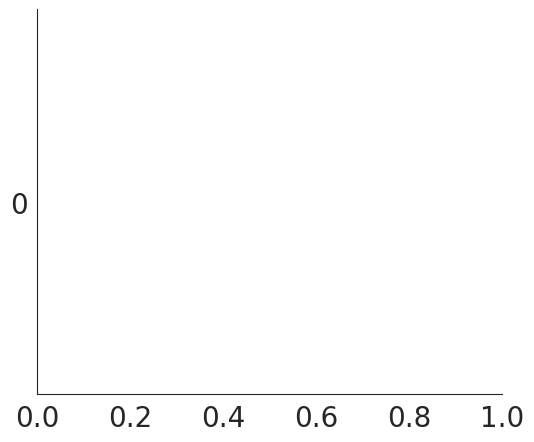

In [ ]:
colors =  ["#7232ad", "#e899bb", '#469fab', 'navy', 'gray']
fig, ax = plt.subplots(figsize = (6,5))
#data1 = [scores_neg, scores_neu, scores_pos]
data1 = [scores_entrancement, scores_relief, scores_awkwardness, scores_samsara, scores_rest]
pairs_to_compare = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3,4)]
for x1, x2 in pairs_to_compare:
    _, p_value = mannwhitneyu(data1[x1], data1[x2], alternative='two-sided')
    print(p_value)
violins = sns.violinplot(data=data1, orient='h', color='#3d73b6cc',
                    boxprops=dict(color=colors[0], facecolor='#3d73b6cc', alpha=0.5, linewidth=3),
                    medianprops=dict(color='#3d73b6cc', linewidth=3), whiskerprops=dict(color='#3d73b6cc', linewidth=3),
                    capprops=dict(color='#3d73b6cc', linewidth=3), zorder=0, showfliers=False, ax=ax)

for i in range(len(data1)):
    myviolin = ax.collections[i*2]
    color = colors[i]
    myviolin.set_facecolor(color)
    myviolin.set_edgecolor(color)
    myviolin.set_alpha(0.5)
    # Now color the scatterplot points manually using the same color as the corresponding violinplot
    y = data1[i]
    x = np.random.normal(i+0.35, 0.1, size=len(y)) # add jitter to x position
    ax.scatter(y,x, facecolor='white', edgecolor = color, s=50, linewidth = 2)


#plt.xticks(ticks=np.arange(0, len(data1)), labels=['Negative', 'Neutral', 'Positive'], rotation=30)
#plt.xticks(ticks=np.arange(0, len(data1))+0.2, labels=['Fear', 'Joy', 'Awe'], rotation=30)
plt.yticks(ticks=np.arange(0, len(data1))+0.2, labels=['entrancement', 'relief', 'anxiety', 'samsara', 'rest'], rotation=0)
plt.xticks(ticks=np.linspace(0.1, 0.5, 3))
plt.xlabel('Probability')
sns.despine()
plt.tight_layout()
#plt.savefig(basedir+'Emotional_Axis_Violinplots_12102023.pdf', transparent = True)

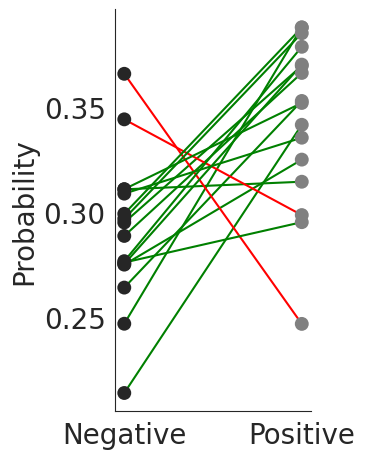

In [ ]:
fig, ax = plt.subplots(figsize = (4, 5))
sns.stripplot(data = [scores_neg, scores_pos], jitter = False, palette='dark:gray', size = 10)
plt.ylabel('Probability')
plt.xticks([0, 1], ['Negative', 'Positive'])
for ii in range(len(scores_neg)):
    if scores_neg[ii] > scores_pos[ii]:
        plt.plot([0, 1], [scores_neg[ii], scores_pos[ii]], color = 'red')
    else:
        plt.plot([0, 1], [scores_neg[ii], scores_pos[ii]], color = 'green')
plt.tight_layout()
plt.savefig(basedir+'EmotionalContent_Differences_19092023.pdf', transparent = True)

In [ ]:
no_music_indices.shape, idx.shape, len(scor_pos)

((10,), (10,), 10)

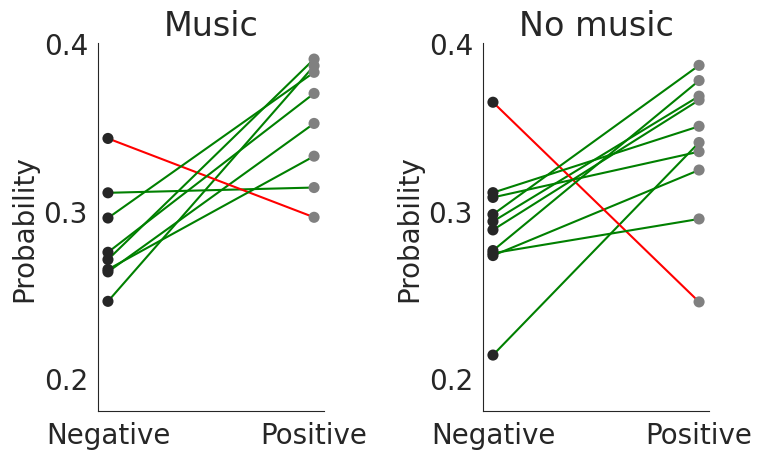

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (8, 5))

titls = ['Music', 'No music']


for (ii, idx) in enumerate([music_indices, no_music_indices]):
    scor_neg = []
    scor_pos = []
    for jj in range(len(scores)):
        if jj in idx:
            scor_neg.append(scores_neg[jj])
            scor_pos.append(scores_pos[jj])

    sns.stripplot(data = [scor_neg, scor_pos], jitter = False, palette='dark:gray', size = 8, ax = ax[ii])
    ax[ii].set_ylim(0.18, 0.4)
    ax[ii].set_ylabel('Probability')
    ax[ii].set_xticks([0, 1], ['Negative', 'Positive'])
    ax[ii].set_yticks([0.2, 0.3, 0.4])
    for rr in range(len(scor_neg)):
        if scor_neg[rr] > scor_pos[rr]:
            ax[ii].plot([0, 1], [scor_neg[rr], scor_pos[rr]], color = 'red')
        else:
            ax[ii].plot([0, 1], [scor_neg[rr], scor_pos[rr]], color = 'green')
    ax[ii].set_title(titls[ii])
plt.tight_layout()
plt.savefig(basedir+'EmotionalContent_Differences_MusicNoMusic_31102023.pdf', transparent = True)

In [ ]:
import scipy.io as sp
mat_file = sp.loadmat("/content/drive/MyDrive/Laptop_Info/BreathWork/RMSSDsummary-2023-04.mat")
cuts_file = sp.loadmat("/content/drive/MyDrive/Laptop_Info/BreathWork/RMSSDsessionphases.mat")

In [ ]:
!pip install tslearn

import numpy as np
import glob
from natsort import natsorted
from tslearn.metrics import dtw_path
from scipy.spatial.distance import cosine
from scipy.stats import zscore as zs

def aligned_series(vec1, vec2, path):
    aligned_vec1 = [vec1[i] for i, j in path]
    aligned_vec2 = [vec2[j] for i, j in path]
    return aligned_vec1, aligned_vec2

def cosine_distance(vec1, vec2):
#    return cosine(vec1, vec2)
    return np.corrcoef(vec1, vec2)[0,1]

file_path = natsorted(glob.glob('/content/drive/MyDrive/Laptop_Info/BreathWork/HR_Data/*.txt', recursive = True))
num_files = len(file_path)
dtw_matrix = np.zeros((num_files, num_files))

for ii, file in enumerate(file_path):
    vec = mat_file['concatRMSSD60secs'][0][ii].ravel()

    for jj, file2 in enumerate(file_path):
        if jj > ii:  # to avoid recomputing for already computed pairs and self-comparison
            vec2 = mat_file['concatRMSSD60secs'][0][jj].ravel()

            path, _ = dtw_path(zs(vec[~np.isnan(vec)]), zs(vec2[~np.isnan(vec2)]))
            aligned_vec, aligned_vec2 = aligned_series(zs(vec[~np.isnan(vec)]), zs(vec2[~np.isnan(vec2)]), path)
            distance = cosine_distance(aligned_vec, aligned_vec2)
            dtw_matrix[ii, jj] = distance
            dtw_matrix[jj, ii] = distance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
file_path = natsorted(glob.glob('/content/drive/MyDrive/Laptop_Info/BreathWork/EnglishTranscripts/*.txt', recursive = True))
len(file_path)

18

In [ ]:
import os
file_path = glob.glob('/content/drive/MyDrive/Laptop_Info/BreathWork/EnglishTranscripts/*English.txt', recursive=True)
no_music = np.array(['ALEROMA', 'AURORA', 'DODO', 'FRESH', 'GIAC', 'LEONIE', 'LINUS', 'LUDO', 'MATT', 'MERIAM'])
participants = np.array(['ARTURO','ABarone','ALEROMA', 'ANTONIA', 'AURORA', 'DODO', 'FRESH', 'GIAC', 'JOANA', 'LEONIE', 'LINUS', 'LUDO', 'MATT', 'MERIAM', 'NATHAN', 'NAZ', 'SANJA', 'SIMONA', 'ISA', 'JOHANNES'])
#participants = np.array([os.path.splitext(os.path.basename(name))[0].replace(" DURING", "") for name in file_path])
music = participants[~np.in1d(participants, no_music)]

music_indices = np.where(~np.in1d(participants, no_music))[0]
no_music_indices = np.where(np.in1d(participants, no_music))[0]

music_music_vals = []
music_no_music_vals = []
no_music_no_music_vals = []

# Using the upper triangular indices, avoiding the diagonal
for i in range(dtw_matrix.shape[0] - 1):
    for j in range(i + 1, dtw_matrix.shape[1]):
        if i in music_indices and j in music_indices:
            music_music_vals.append(dtw_matrix[i, j])
        elif i in no_music_indices and j in no_music_indices:
            no_music_no_music_vals.append(dtw_matrix[i, j])
        else:
            music_no_music_vals.append(dtw_matrix[i, j])

NameError: name 'dtw_matrix' is not defined

<Axes: >

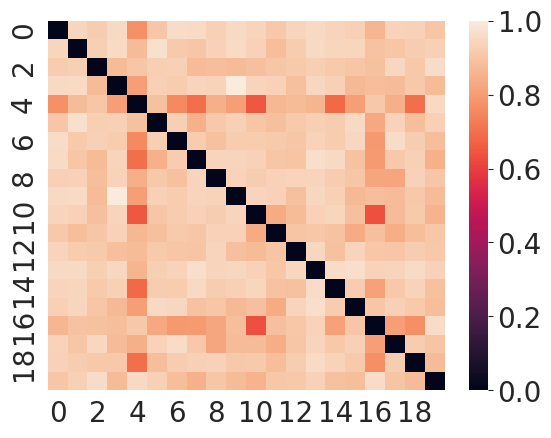

In [ ]:
sns.heatmap(dtw_matrix)

1.0
1.0
1.0


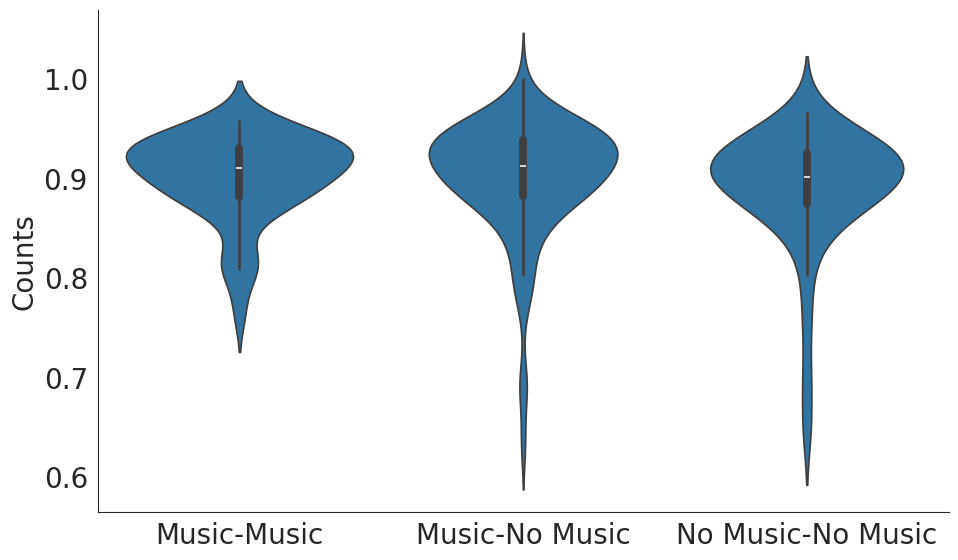

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a single list of data and labels for seaborn boxplot
data = music_music_vals + music_no_music_vals + no_music_no_music_vals
labels = ["Music-Music"] * len(music_music_vals) + ["Music-No Music"] * len(music_no_music_vals) + ["No Music-No Music"] * len(no_music_no_music_vals)

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=labels, y=data)
pairs_to_compare = [(0, 1), (1, 2), (0, 2)]
for x1, x2 in pairs_to_compare:
    _, p_value = mannwhitneyu(data[x1], data[x2], alternative='two-sided')
    print(p_value)
    if (x1 == 0)*(x2 == 2):
       signifStars(x1+0.125, x2+0.125, 1.2*max(np.max(data[x1]), np.max(data[x2])), 0.8, ax, p_value, printP=False)
    else:
      signifStars(x1+0.125, x2+0.125, 1.1*max(np.max(data[x1]), np.max(data[x2])), 0.8, ax, p_value, printP=False)
#sns.histplot(data = [music_music_vals, music_no_music_vals, no_music_no_music_vals], common_norm = False, bins = 20)
#sns.histplot(data = [music_music_vals, music_no_music_vals, no_music_no_music_vals], kde = False, stat = 'density', fill = True, element = 'step', alpha = 0.5, lw = 3, bins = 10)
#sns.histplot(data = [music_music_vals, music_no_music_vals, no_music_no_music_vals], common_norm = False, bins = 20)

plt.ylabel('Counts')
plt.tight_layout()

In [ ]:
data[0]

0.9441711698905936

0.5610830422683342
0.1308449121795347
0.3248680344391065


AttributeError: PolyCollection.set() got an unexpected keyword argument 'boxprops'

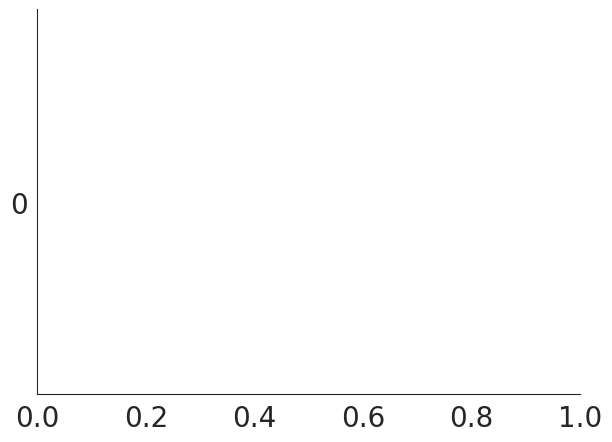

In [ ]:
colors =  ["#f0990c", "#bfa478", 'gray']
fig, ax = plt.subplots(figsize = (7,5))

data1 = [music_music_vals, music_no_music_vals, no_music_no_music_vals]
pairs_to_compare = [(0, 1), (1, 2), (0, 2)]
for x1, x2 in pairs_to_compare:
    _, p_value = mannwhitneyu(data1[x1], data1[x2], alternative='two-sided')
    print(p_value)

violins = sns.violinplot(data=data1, orient='h', color='#3d73b6cc',
                    boxprops=dict(color=colors[0], facecolor='#3d73b6cc', alpha=0.5, linewidth=3),
                    medianprops=dict(color='#3d73b6cc', linewidth=3), whiskerprops=dict(color='#3d73b6cc', linewidth=3),
                    capprops=dict(color='#3d73b6cc', linewidth=3), zorder=0, showfliers=False, ax=ax)

for i in range(len(data1)):
    myviolin = ax.collections[i*2]
    color = colors[i]
    myviolin.set_facecolor(color)
    myviolin.set_edgecolor(color)
    myviolin.set_alpha(0.5)
    # Now color the scatterplot points manually using the same color as the corresponding violinplot
    y = np.array(data1[i])
    x = np.random.normal(i+0.35, 0.1, size=len(y)) # add jitter to x position
    ax.scatter(y,x, facecolor='white', edgecolor = color, s=50, linewidth = 2)

#plt.xticks(ticks=np.arange(0, len(data1)), labels=['Negative', 'Neutral', 'Positive'], rotation=30)
#plt.xticks(ticks=np.arange(0, len(data1))+0.2, labels=['Fear', 'Joy', 'Awe'], rotation=30)
plt.yticks(ticks=np.arange(0, len(data1))+0.2, labels=['Music-music', 'Music-no music', 'No music-no music'], rotation=0)
plt.xticks(ticks=np.linspace(0.5, 1, 3))
plt.xlabel('Aligned Pearson correlation')
sns.despine()
plt.tight_layout()
#plt.savefig(basedir+'SimilarityHRV_MusicNoMusic_Violinplots_31102023.pdf', transparent = True)

In [ ]:
from scipy.stats import mannwhitneyu as mu
#music_music_vals + music_no_music_vals + no_music_no_music_vals
mu(music_no_music_vals, no_music_no_music_vals).pvalue

0.7372544021223291

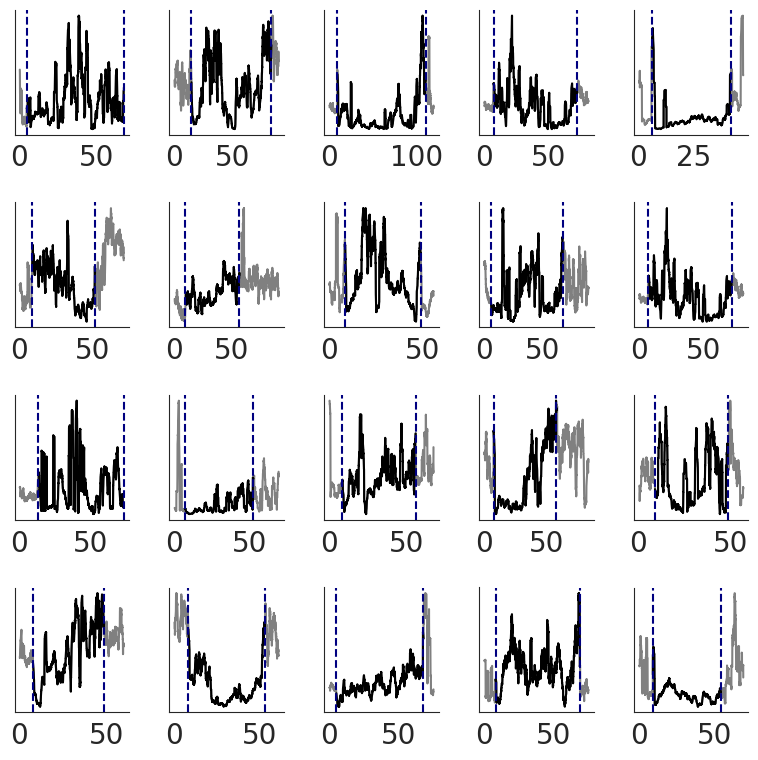

In [ ]:
fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (8, 8))
avgs_pre = np.full(len(participants), np.nan)
avgs_during = np.full(len(participants), np.nan)
avgs_post = np.full(len(participants), np.nan)


for ii in range(len(participants)):
    axi = ax.flat[ii]
    time = mat_file['concatRMSSD60secsTime'][0][ii].ravel()
    vec = mat_file['concatRMSSD60secs'][0][ii].ravel()
    music = cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()

    st = np.where(np.diff(cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()))[0][0]
    end = np.where(np.diff(cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()))[0][1]
    #coef_pre = computeSlopes(vec[:st], time[:st])
    #coef_during = computeSlopes(vec[st:end], time[st:end])
    #coef_post = computeSlopes(vec[end:], time[end:])
    axi.plot(time, vec, color = 'gray')
    axi.plot(time[st:end], vec[st:end], color = 'black')

    #axi.plot(time[:st], coef_pre*time[:st] + time[0], color = 'orange') #*(time[end] - time[st])
    #axi.plot(time[st:end], coef_during*time[st:end] + time[st], color = 'red') #*(time[end] - time[st])
    #axi.plot(time[end:], coef_post*time[end:] + time[end], color = 'orange') #*(time[end] - time[st])
    #axi.set_title(str(np.round(ratio[ii],3)))
    avgs_pre[ii] = np.nanmedian(vec[:st])
    avgs_during[ii] = np.nanmedian(vec[st:end])
    avgs_post[ii] = np.nanmedian(vec[end:])
    #avgs_pre[ii] = (np.nanmax(vec[:st]) - np.nanmin(vec[:st]))/st
    #avgs_during[ii] = (np.nanmax(vec[st:end]) - np.nanmin(vec[st:end]))/(end-st)
    #avgs_post[ii] = (np.nanmax(vec[end:]) - np.nanmin(vec[end:]))/(vec.shape[0] - end)
    axi.axvline(time[st], ls = '--', color = 'navy')
    axi.axvline(time[end], ls = '--', color = 'navy')
    # axi.set_xticks([])
    axi.set_yticks([])
sns.despine()
plt.tight_layout()

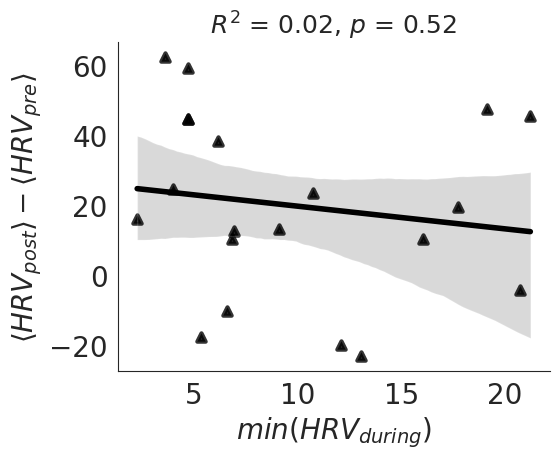

In [ ]:
import scipy.stats as sts

fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x=avgs_during, y=avgs_post-avgs_pre, ci = 90, color = 'black', label = 'All', marker = '^', line_kws = {'linewidth':4}, scatter_kws = {'linewidth':3})
slope, intercept, r, p, std_err = sts.linregress(x=avgs_during, y=avgs_post-avgs_pre)
plt.title('$R^2$ = '+str(np.round(r**2,2))+', $p$ = '+str(np.round(p,3)), fontsize = 18)
plt.xlabel(r"$min(HRV_{during})$", fontsize = 20)
plt.ylabel(r"$\langle HRV_{post} \rangle - \langle HRV_{pre} \rangle$", fontsize = 20)
#plt.ylabel('Positive emotionns', fontsize = 20)
plt.tight_layout()
plt.savefig(basedir+'MinHRVvduring_HRV_prepost_05122023.pdf', transparent = True)

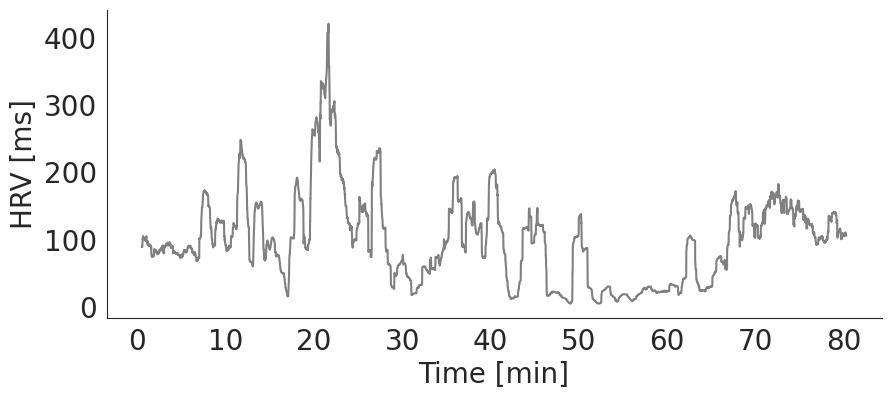

In [ ]:
ii = 3
time = mat_file['concatRMSSD60secsTime'][0][ii].ravel()
vec = mat_file['concatRMSSD60secs'][0][ii].ravel()
fig, ax = plt.subplots(figsize = (10, 4))
plt.plot(time, vec, color = 'gray')
plt.xlabel('Time [min]')
plt.ylabel('HRV [ms]')
plt.savefig(basedir+'HRV_Example_03112024.pdf', transparent = True)

In [ ]:
import pandas as pd

vars_pre = np.full(len(list(scores.keys())), np.nan)
vars_during = np.full(len(list(scores.keys())), np.nan)
vars_post = np.full(len(list(scores.keys())), np.nan)

# Number of bootstrap samples
n_bootstrap = 1000


for ii, key in enumerate(scores.keys()):
    time = mat_file['concatRMSSD60secsTime'][0][ii].ravel()
    vec = mat_file['concatRMSSD60secs'][0][ii].ravel()
    music = cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()

    st = np.where(np.diff(cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()))[0][0]-1
    end = np.where(np.diff(cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()))[0][1]-1

    # Find the minimum size among the time series
    min_size = min(len(vec[:st]), len(vec[st:end]), len(vec[end:]))
    # Initialize arrays to hold bootstrap variances
    bootstrap_var_pre = np.zeros(n_bootstrap)
    bootstrap_var_during = np.zeros(n_bootstrap)
    bootstrap_var_post = np.zeros(n_bootstrap)
    # Perform bootstrapping
    for i in range(n_bootstrap):
        sample_pre = np.random.choice(vec[:st], min_size, replace=True)
        sample_during = np.random.choice(vec[st:end], min_size, replace=True)
        sample_post = np.random.choice(vec[end:], min_size, replace=True)

        bootstrap_var_pre[i] = np.nanstd(sample_pre)
        bootstrap_var_during[i] = np.nanstd(sample_during)
        bootstrap_var_post[i] = np.nanstd(sample_post)

    # Calculate mean and confidence intervals for variances
    vars_pre[ii] = np.nanmean(bootstrap_var_pre)
    vars_during[ii] = np.nanmean(bootstrap_var_during)
    vars_post[ii] = np.nanmean(bootstrap_var_post)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
def signifStars(x1, x2, scale, v, ax, p, printP = False, fontsiz = 16):
    # y, col = scale*np.max(v), 'k'
    ax.plot([x1, x2], [scale, scale], lw=1.5, c='k')
    siz = fontsiz
    if np.logical_and(p > 0.5, p<1):
        p = 1-p
    if p < 0.001:
        stringy = '***'
    elif p < 0.01:
        stringy = '**'
    elif p < 0.05:
        stringy = '*'
    elif p > 0.05:
        if printP == False:
            stringy = 'ns'
        else:
            stringy = str(np.round(p,3))
    if ~np.isnan(np.percentile(np.abs(v),99)):
        ax.text((x1+x2)*.5, scale, stringy, ha='center', va='bottom', color='k', size = siz)

0.018494940419589944
0.03022625498203607
0.7203098459695906


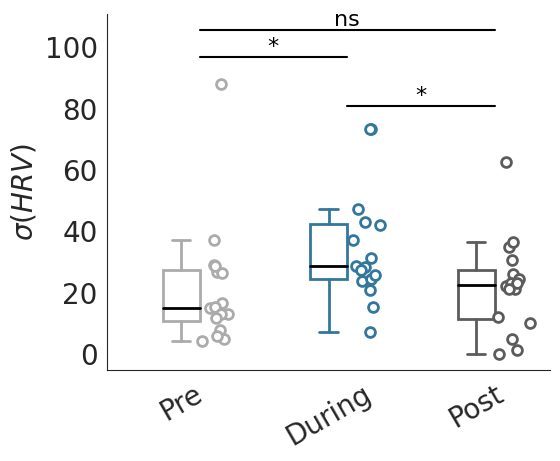

In [ ]:
from scipy.stats import mannwhitneyu
colors =  ["#ababab", "#32789c", '#5c5c5c']
fig, ax = plt.subplots(figsize = (6,5))

data1 = [vars_pre, vars_during, vars_post]
sns.boxplot(data=data1, orient='v', ax=ax, color='white', medianprops={'color': 'black', 'linewidth':2}, showcaps=True, showfliers=False,
            boxprops=dict(facecolor='white', edgecolor='black'), width = 0.25)

# Color boxes, whiskers, and caps
for i, (box, color) in enumerate(zip(ax.patches, colors)):
    box.set_edgecolor(color)
    box.set_linewidth(2)

    for j in range(4):  # 2 whiskers and 2 caps
        line = ax.lines[i * 5 + j]
        line.set_color(color)
        line.set_linewidth(2)

# Add jitter points
for i, y in enumerate(data1):
    col = colors[i]
    x = np.random.normal(i, 0.05, size=len(y))+0.25  # add jitter to x position
    ax.scatter(x, y, facecolor='white', edgecolor=col, s=50, linewidth=2)

plt.xticks(ticks=np.arange(0, len(data1)), labels=['Pre', 'During', 'Post'], rotation=30)
plt.ylabel('$\sigma(HRV)$')
sns.despine()

pairs_to_compare = [(0, 1), (1, 2), (0, 2)]
for x1, x2 in pairs_to_compare:
    _, p_value = mannwhitneyu(data1[x1], data1[x2], alternative='two-sided')
    print(p_value)
    if (x1 == 0)*(x2 == 2):
       signifStars(x1+0.125, x2+0.125, 1.2*max(np.max(data1[x1]), np.max(data1[x2])), 0.8, ax, p_value, printP=False)
    else:
      signifStars(x1+0.125, x2+0.125, 1.1*max(np.max(data1[x1]), np.max(data1[x2])), 0.8, ax, p_value, printP=False)
plt.tight_layout()
plt.savefig(basedir+'PreDuringPost_HRVv_boxplots_10102023.svg', transparent = True)

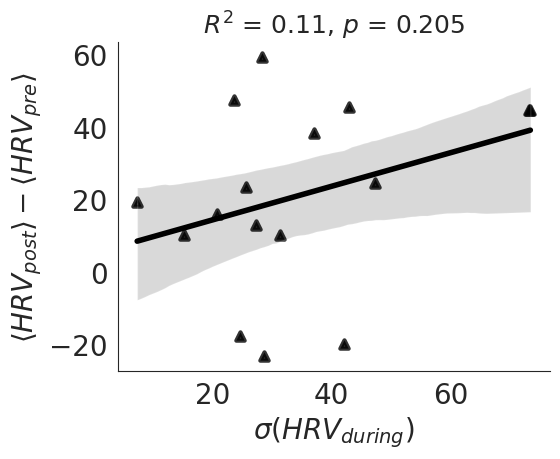

In [ ]:
import scipy.stats as sts

fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x=vars_during, y=avgs_post-avgs_pre, ci = 90, color = 'black', label = 'All', marker = '^', line_kws = {'linewidth':4}, scatter_kws = {'linewidth':3})
slope, intercept, r, p, std_err = sts.linregress(x=vars_during, y=avgs_post-avgs_pre)
plt.title('$R^2$ = '+str(np.round(r**2,2))+', $p$ = '+str(np.round(p,3)), fontsize = 18)
plt.xlabel(r"$\sigma(HRV_{during})$", fontsize = 20)
plt.ylabel(r"$\langle HRV_{post} \rangle - \langle HRV_{pre} \rangle$", fontsize = 20)
#plt.ylabel('Positive emotionns', fontsize = 20)
plt.tight_layout()
plt.savefig(basedir+'HRVvduring_HRV_prepost_10102023.pdf', transparent = True)

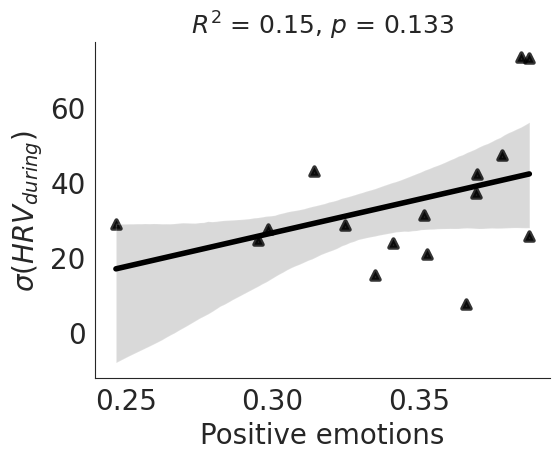

In [ ]:
import scipy.stats as sts

fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x=scores_pos, y=vars_during, ci = 90, color = 'black', label = 'All', marker = '^', line_kws = {'linewidth':4}, scatter_kws = {'linewidth':3})
slope, intercept, r, p, std_err = sts.linregress(x=scores_pos, y=vars_during)
plt.title('$R^2$ = '+str(np.round(r**2,2))+', $p$ = '+str(np.round(p,3)), fontsize = 18)
plt.xlabel(r"Positive emotions", fontsize = 20)
plt.ylabel(r"$\sigma(HRV_{during})$", fontsize = 20)

plt.tight_layout()
plt.savefig(basedir+'HRVvduring_positive emotions_10102023.pdf', transparent = True)

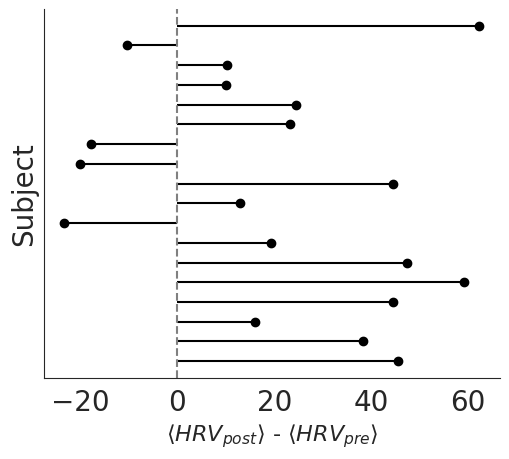

In [ ]:
def plot_prePost(vect_pre, vect_post):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    df = pd.DataFrame(np.column_stack([vect_pre, vect_post]), columns=['pre', 'post'])
    my_range = range(len(df.index))

    fig, ax = plt.subplots(figsize = (5.5,5))
    # The horizontal plot is made using the hline function
    plt.hlines(y=my_range, xmin=df['post'], xmax=df['pre'], color='black', alpha=1)
    plt.scatter(df['post'], my_range, color='black', alpha=1, label='post')
    plt.xlabel(r"$\langle HRV_{post}\rangle$ - $\langle HRV_{pre}\rangle$", fontsize = 16)
    plt.ylabel('Subject')
    #plt.yticks(np.arange(0, 16, 1), np.arange(0, 16, 1)+1)
    plt.yticks([])
    plt.axvline(0, ls = '--', color = 'gray')
    plt.tight_layout()
plot_prePost(np.zeros(avgs_post.shape[0]), avgs_post-avgs_pre)
#plt.savefig(basedir+'HRV_PrePost_All_10062023.svg', transparent = True)

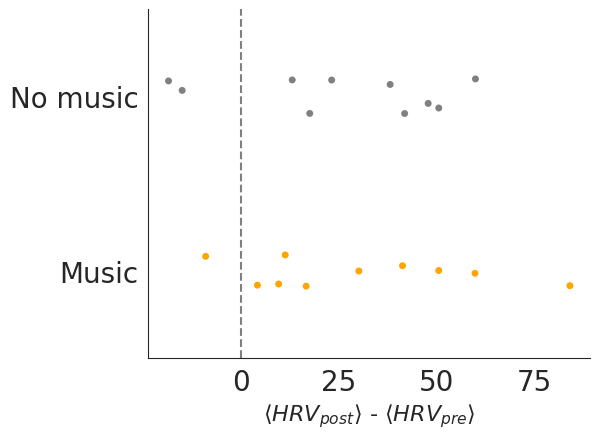

In [ ]:
diffs = avgs_post-avgs_pre
sns.stripplot(data = [diffs[no_music_indices], diffs[music_indices]], orient = 'h', palette = ['grey', 'orange'])
plt.yticks([0, 1], ['No music', 'Music'])
plt.xlabel(r"$\langle HRV_{post}\rangle$ - $\langle HRV_{pre}\rangle$", fontsize = 16)
plt.axvline(0, ls = '--', color = 'gray')
plt.tight_layout()
#plt.savefig(basedir+'HRV_PrePost_MusicNoMusic_28082024.svg', transparent = True)

In [ ]:
from scipy.stats import mannwhitneyu as mu
mu(diffs[no_music_indices], diffs[music_indices])

MannwhitneyuResult(statistic=50.5, pvalue=1.0)

In [ ]:
diffs[no_music_indices], diffs[music_indices]

(array([ 13.00548117,  47.8504604 ,  59.97812   ,  17.50078411,
        -15.20203364,  50.56843831, -18.69460043,  41.82366817,
         23.11780652,  38.10681187]),
 array([59.86848058, 41.27774087, 50.56843831, 16.58088888,  9.53011185,
        11.21406272, -9.17945827, 84.19355344,  4.0860114 , 30.09070139]))

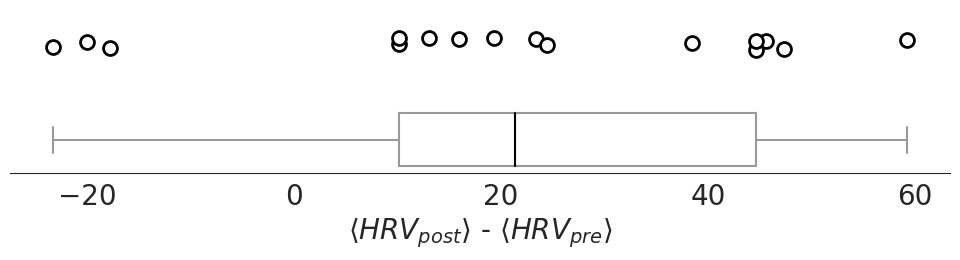

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a new figure with two subplots, sharing x-axis
fig, (ax_strip, ax_box) = plt.subplots(2, sharex=True,
                                       gridspec_kw={"height_ratios": (.5,.5)}, figsize = (10, 3))

# Draw the box plot on the first subplot
sns.boxplot(data=arr_postpre, orient='h', ax=ax_box, color='white', medianprops={'color': 'black'}, showcaps=True, showfliers=False)

# Get the boxes from the plot and set their properties
for i, artist in enumerate(ax_box.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = 'black'
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them and set the linecolor on each to the facecolor
    for j in range(i*6, i*6+6):
        line = ax_box.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        line.set_lw(2)

# Draw the strip plot on the second subplot
sns.stripplot(data=arr_postpre, orient='h', ax=ax_strip, size = 10, facecolor = 'white', edgecolor = 'black', linewidth = 2)

# Set the title for the box plot
ax_strip.spines['bottom'].set_visible(False)
ax_strip.spines['left'].set_visible(False)
ax_box.spines['left'].set_visible(False)
ax_box.set_yticks([])
ax_box.set_xlabel(r"$\langle HRV_{post}\rangle$ - $\langle HRV_{pre}\rangle$")
plt.tight_layout()
#plt.savefig(basedir+'HRV_PrePost_All_Stats_17072023.svg', transparent = True)

In [ ]:
from scipy.signal import butter, filtfilt
import pandas as pd

def lowpass_filter(time_series, cutoff_frequency, sample_frequency, order=4):
    # Convert time_series to pandas Series for easier handling
    time_series = pd.Series(time_series)

    # Interpolate NaNs using linear method
    time_series.interpolate(method='linear', inplace=True)

    # Backward fill to handle any remaining NaNs at the start
    time_series.bfill(inplace=True)
    # Forward fill to handle any remaining NaNs at the end
    time_series.ffill(inplace=True)

    # Calculate the Nyquist frequency
    nyquist_frequency = 0.5 * sample_frequency

    # Normalize the cutoff frequency by the Nyquist frequency
    normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency

    # Get the filter coefficients
    b, a = butter(order, normalized_cutoff_frequency, btype='low', analog=False)

    # Apply the filter to the time series using filtfilt for a zero phase filter
    filtered_time_series = filtfilt(b, a, time_series)

    # Return the filtered time series
    return filtered_time_series


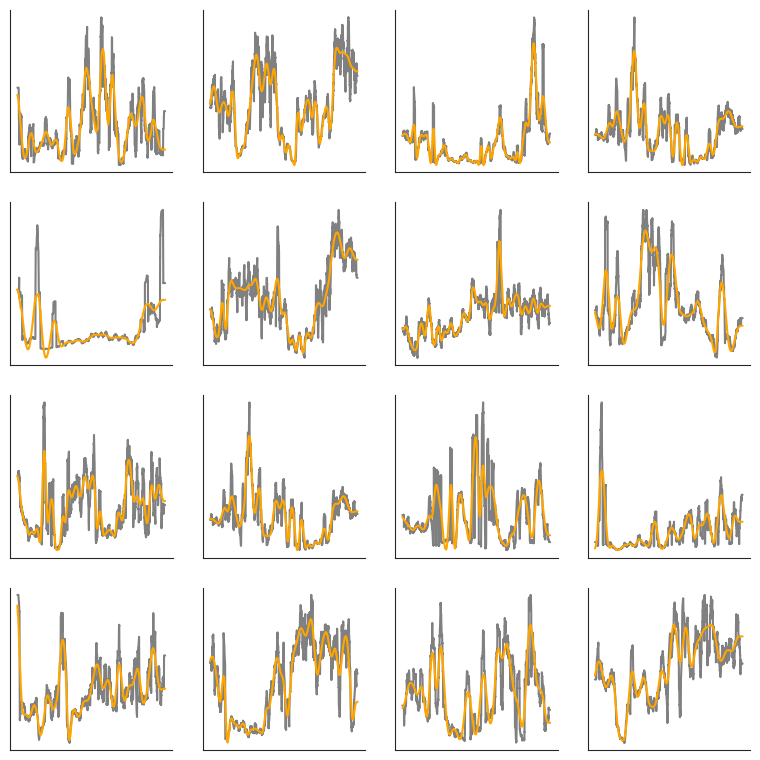

In [ ]:
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (8, 8))
for ii, key in enumerate(scores.keys()):
    axi = ax.flat[ii]
    time = mat_file['concatRMSSD60secsTime'][0][ii].ravel()
    vec = mat_file['concatRMSSD60secs'][0][ii].ravel()
    music = cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()

    st = np.where(np.diff(cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()))[0][0]
    end = np.where(np.diff(cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()))[0][1]
    vec_slow = lowpass_filter(vec, 0.25, 1/np.nanmedian(np.diff(time)), order=4)
    axi.plot(time, vec, color = 'gray')
    axi.plot(time, vec_slow, color = 'orange')
    axi.set_xticks([])
    axi.set_yticks([])
sns.despine()
plt.tight_layout()

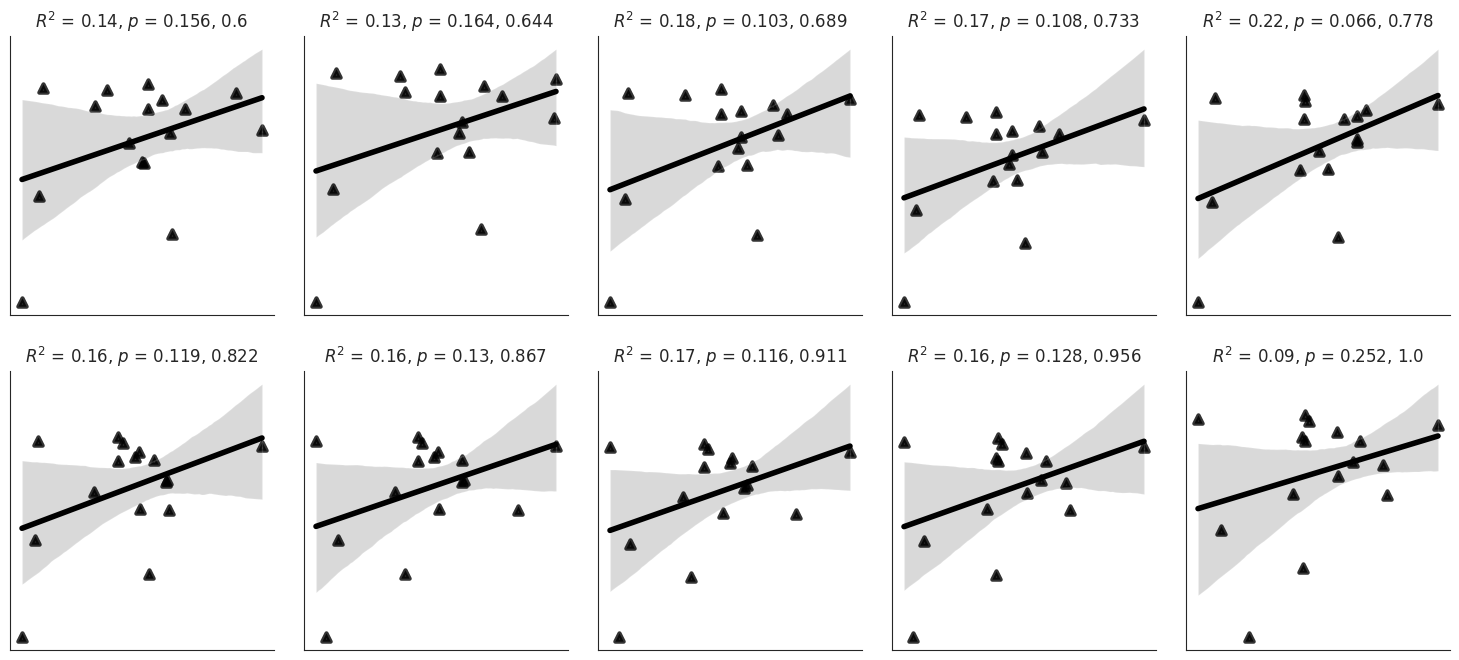

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 7))

freq = 0.25
for jj, freq in enumerate(np.linspace(0.6, 1, 10)):
    axi = ax.flat[jj]
    nPeaks_pre = np.full(len(list(scores.keys())), np.nan)
    nPeaks_during = np.full(len(list(scores.keys())), np.nan)
    nPeaks_post = np.full(len(list(scores.keys())), np.nan)
    for ii, key in enumerate(scores.keys()):
        time = mat_file['concatRMSSD60secsTime'][0][ii].ravel()
        vecs = mat_file['concatRMSSD60secs'][0][ii].ravel()
        music = cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()

        st = np.where(np.diff(music))[0][0]
        end = np.where(np.diff(music))[0][1]
        vec = lowpass_filter(vecs, freq, 1/np.nanmedian(np.diff(time)), order=4)
        peaks, _ = find_peaks(vec[:st])
        nPeaks_pre[ii] = peaks.shape[0]/st

        peaks, _ = find_peaks(vec[st:end])
        nPeaks_during[ii] = peaks.shape[0]/(end-st)

        peaks, _ = find_peaks(vec[end:])
        nPeaks_post[ii] = peaks.shape[0]/(vec.shape[0] - end)

    #pikDif = (nPeaks_post - nPeaks_pre)/(nPeaks_post + nPeaks_pre)
    pikDif = nPeaks_post - nPeaks_pre

    xx = pikDif.copy()
    yy = ratio.copy()
    yy= yy[~np.isnan(xx)]
    xx= xx[~np.isnan(xx)]

    sns.regplot(x = xx, y = yy, ci = 90, color = 'black', label = 'All', marker = '^', line_kws = {'linewidth':4}, scatter_kws = {'linewidth':3}, ax = axi)
    slope_all, intercept, r_all, p_all, std_err = sts.linregress(x=xx, y=yy)
    axi.set_title('$R^2$ = '+str(np.round(r_all**2,2))+', $p$ = '+str(np.round(p_all,3))+', '+str(np.round(freq,3)), fontsize = 12)
    axi.set_xticks([])
    axi.set_yticks([])
plt.tight_layout()

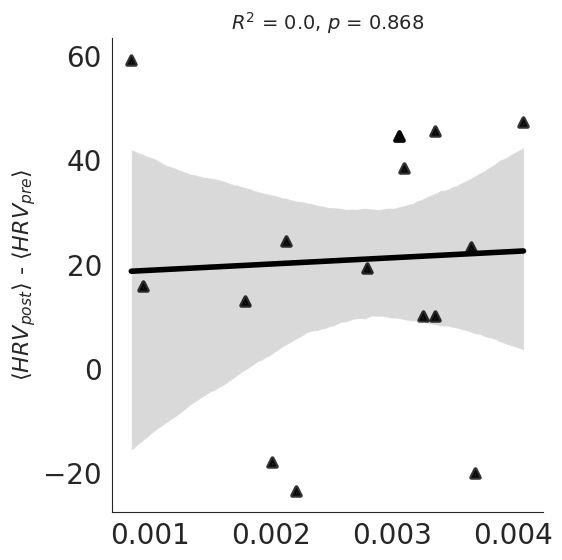

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
from scipy.stats import zscore as zs

freq = 0.9
prom = 0.1
difs = avgs_post - avgs_pre

nPeaks_pre = np.full(len(list(scores.keys())), np.nan)
nPeaks_during = np.full(len(list(scores.keys())), np.nan)
nPeaks_post = np.full(len(list(scores.keys())), np.nan)
for ii, key in enumerate(scores.keys()):
    time = mat_file['concatRMSSD60secsTime'][0][ii].ravel()
    vecs = mat_file['concatRMSSD60secs'][0][ii].ravel()
    music = cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()

    st = np.where(np.diff(music))[0][0]
    end = np.where(np.diff(music))[0][1]
    vec = lowpass_filter(vecs, freq, 1/np.nanmedian(np.diff(time)), order=4)
    peaks, _ = find_peaks(vec[:st])#, prominence=prom*(np.nanmax(vec[:st]) - np.nanmin(vec[:st])))
    nPeaks_pre[ii] = peaks.shape[0]/st

    peaks, _ = find_peaks(vec[st:end], prominence=prom*(np.nanmax(vec[st:end]) - np.nanmin(vec[st:end])))
    nPeaks_during[ii] = peaks.shape[0]/(end-st)

    peaks, _ = find_peaks(vec[end:])#, prominence=prom*(np.nanmax(vec[end:]) - np.nanmin(vec[end:])))
    nPeaks_post[ii] = peaks.shape[0]/(vec.shape[0] - end)

pikDif = zs(nPeaks_post - nPeaks_pre)

xx = nPeaks_during.copy()
yy = difs.copy()
yy= yy[~np.isnan(xx)]
xx= xx[~np.isnan(xx)]

sns.regplot(x = xx, y = yy, ci = 90, color = 'black', label = 'All', marker = '^', line_kws = {'linewidth':4}, scatter_kws = {'linewidth':3})
slope_all, intercept, r_all, p_all, std_err = sts.linregress(x=xx, y=yy)
plt.title('$R^2$ = '+str(np.round(r_all**2,2))+', $p$ = '+str(np.round(p_all,3)), fontsize = 14)
#plt.xticks(np.linspace(-2, 2, 5), fontsize = 16)
#plt.yticks(np.linspace(-0.2, 0.2, 5), fontsize = 16)
#plt.ylim(-0.25, 0.3)
plt.ylabel('n_{peaks}^{during}', fontsize = 16)
plt.ylabel(r"$\langle HRV_{post}\rangle$ - $\langle HRV_{pre}\rangle$", fontsize = 16)
plt.tight_layout()

In [ ]:
subjects = []
for file in glob.glob('/content/drive/MyDrive/Laptop_Info/BreathWork/EnglishTranscripts/*.txt', recursive = True):
    subjects.append(file.split('/')[-1].split('-')[0].split(' ')[0].capitalize())

In [ ]:
PositivityRatio_df = pd.DataFrame(ratio.reshape(-1,1).T, columns = subjects)
PositivityRatio_df.to_csv(basedir+'Positivity_Ratio_19092023.csv', index = False)

In [ ]:
ScoresPos_df = pd.DataFrame(scores_pos.reshape(-1,1).T, columns = subjects)
ScoresPos_df.to_csv(basedir+'ScoresPos.csv', index = False)

Scoresneg_df = pd.DataFrame(scores_neg.reshape(-1,1).T, columns = subjects)
Scoresneg_df.to_csv(basedir+'ScoresNeg.csv', index = False)

In [ ]:
peaksDuring_df = pd.DataFrame(nPeaks_during.reshape(-1,1).T, columns = subjects)
peaksDuring_df.to_csv(basedir+'PeaksDuring.csv', index = False)

In [ ]:
difs = avgs_post - avgs_pre
HRV_postPre_df = pd.DataFrame(difs.reshape(-1,1).T, columns = subjects)
HRV_postPre_df.to_csv(basedir+'HRV_postPre.csv', index = False)

In [ ]:
nPeaks_df = pd.DataFrame(xx.reshape(-1,1).T, columns = subjects)
nPeaks_df.to_csv('/content/drive/MyDrive/Laptop_Info/BreathWork/NumberOfPeaks_PostPre.csv', index = False)

Text(0.5, 0, 'Time [min]')

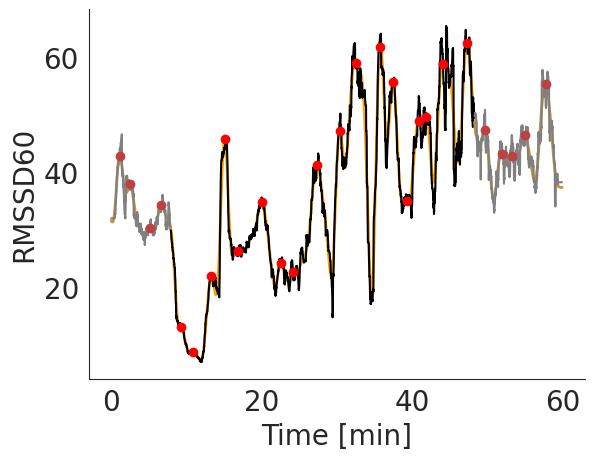

In [ ]:
peaks, _ = find_peaks(vec[:st])#, prominence=0.2*(np.nanmax(vec[:st]) - np.nanmin(vec[:st])))
plt.plot(time[:st], vec[:st], color = sns.desaturate('orange', 0.5), lw = 2)
plt.plot(time[:st], vecs[:st], color = 'gray')
plt.plot(time[peaks], vec[peaks], 'o', color = sns.desaturate('red', 0.5))

peaks, _ = find_peaks(vec[st:end])#, prominence=0.1*(np.nanmax(vec[st:end]) - np.nanmin(vec[st:end])))
plt.plot(time[st:end], vec[st:end], color = 'orange', lw = 2)
plt.plot(time[st:end], vecs[st:end], color = 'black')
plt.plot(time[peaks+st], vec[peaks+st], 'o', color = 'red')

peaks, _ = find_peaks(vec[end:])#, prominence=0.1*(np.nanmax(vec[end:]) - np.nanmin(vec[end:])))
plt.plot(time[end:], vec[end:], color = sns.desaturate('orange', 0.5), lw = 2)
plt.plot(time[end:], vecs[end:], color = 'gray')
plt.plot(time[peaks+end], vec[peaks+end], 'o', color = sns.desaturate('red', 0.5))

plt.ylabel('RMSSD60')
plt.xlabel('Time [min]')


In [ ]:
dcoef_pre = np.full(len(list(scores.keys())), np.nan)
coef_during = np.full(len(list(scores.keys())), np.nan)
coef_post = np.full(len(list(scores.keys())), np.nan)
for ii, key in enumerate(scores.keys()):
    time = mat_file['concatRMSSD60secsTime'][0][ii].ravel()
    vec = mat_file['concatRMSSD60secs'][0][ii].ravel()
    st = np.where(np.diff(cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()))[0][0]
    end = np.where(np.diff(cuts_file[list(cuts_file.keys())[-1]][0][ii].ravel()))[0][1]

    coef_pre[ii] = computeSlopes(vec[:st], time[:st])
    coef_during[ii] = computeSlopes(vec[st:end], time[st:end])
    coef_post[ii] = computeSlopes(vec[end:], time[end:])

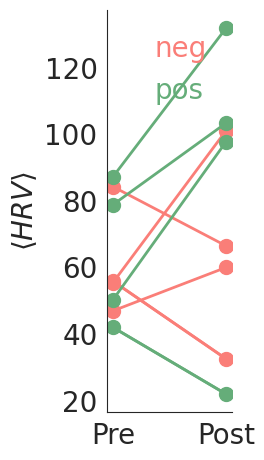

In [ ]:
plt.subplots(figsize = (3, 5))
for ii in range(len(neg)):
    plt.plot(['Pre', 'Post'], [avgs_pre[neg[ii]], avgs_post[neg[ii]]], color = '#FA7E78', marker = 'o', lw = 2, ms = 10)
plt.plot(['Pre', 'Post'], [avgs_pre[neg[ii]], avgs_post[neg[ii]]], color = '#FA7E78', lw = 2, label = 'neg')
for ii in range(len(pos)):
    plt.plot(['Pre', 'Post'], [avgs_pre[pos[ii]], avgs_post[pos[ii]]], color = '#65AD79', marker = 'o', lw = 2, ms = 10)
plt.plot(['Pre', 'Post'], [avgs_pre[pos[ii]], avgs_post[pos[ii]]], color = '#65AD79', lw = 2, label = 'pos')
plt.legend(frameon=False, handlelength=0, labelcolor='linecolor')
plt.ylabel(r"$\langle HRV\rangle$")
plt.tight_layout()

Text(0.5, 0, '$\\langle HRV_{post}\\rangle$ - $\\langle HRV_{pre}\\rangle$')

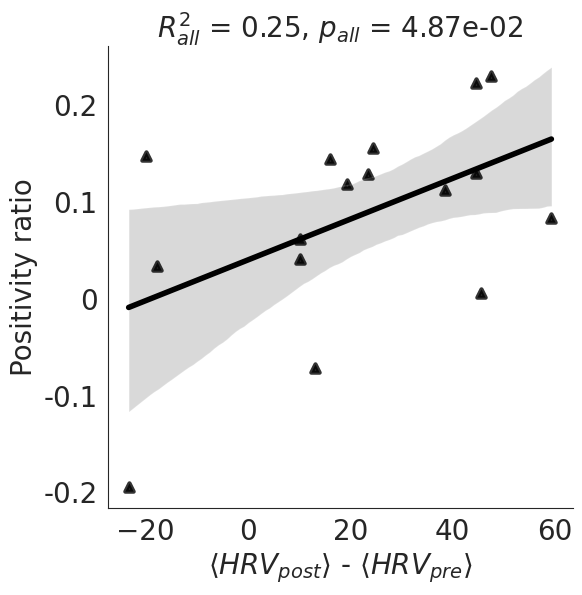

In [ ]:
xx = avgs_post - avgs_pre

#xx = nPeaks_during.copy()
#xx = coef_post - coef_pre
yy = ratio.copy()
yy= yy[~np.isnan(xx)]
xx= xx[~np.isnan(xx)]

fig, ax = plt.subplots(figsize = (6,6))
sns.regplot(x = xx, y = yy, ci = 90, color = 'black', label = 'All', marker = '^', line_kws = {'linewidth':4}, scatter_kws = {'linewidth':3})
slope_all, intercept, r_all, p_all, std_err = sts.linregress(x=xx, y=yy)
plt.title('$R_{all}^2$ = '+str(np.round(r_all**2,3))+', $p_{all}$ = '+f"{p_all:.2e}", fontsize = 20)
plt.yticks([-0.2, -0.1, 0, 0.1, 0.2], labels = ['-0.2', '-0.1', '0', '0.1', '0.2'], fontsize = 20)
#plt.xlim([-30, 65])
plt.ylabel('Positivity ratio', fontsize = 20)
plt.xlabel(r"$\langle HRV_{post}\rangle$ - $\langle HRV_{pre}\rangle$", fontsize = 20)

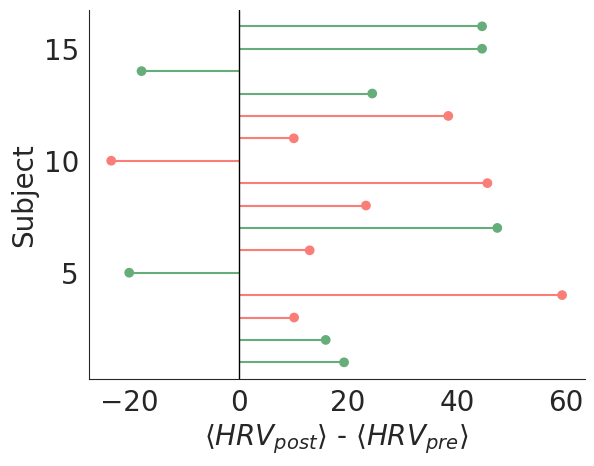

In [ ]:
def plot_prePost(vect_pre, vect_post, pos, neg):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    df = pd.DataFrame(np.column_stack([vect_pre, vect_post]), columns=['pre', 'post'])
    df['diff'] = df['post'] - df['pre']

    # Reorder it following the values of the first value:
    ordered_df = df.sort_values(by='pre')
    my_range = range(1, len(df.index) + 1)

    # Get the reordered indices of pos and neg
    pos_reordered = ordered_df.index.isin(pos).nonzero()[0]
    neg_reordered = ordered_df.index.isin(neg).nonzero()[0]

    # Color the points based on the pos and neg indices
    colors = ['#65AD79' if i in pos_reordered else '#FA7E78' if i in neg_reordered else '#c2c2c200' for i in range(len(df))]

    # The horizontal plot is made using the hline function
    plt.hlines(y=my_range, xmin=0, xmax=ordered_df['diff'], color=colors)

    # Plot the scatter points with the specified colors
    plt.scatter(ordered_df['diff'], my_range, color=colors, label='Difference (post - pre)')
    plt.axvline(x=0, color='black', linewidth=1)

    # plt.legend()
    plt.xlabel(r"$\langle HRV_{post}\rangle$ - $\langle HRV_{pre}\rangle$")
    plt.ylabel('Subject')

    # Show the graph
    plt.show()

pos = np.argsort(ratio)[::-1][:8]
neg = np.argsort(ratio)[::-1][-8:]

plot_prePost(avgs_pre, avgs_post, pos, neg)
